# **La dominance budgétaire: analyse empirique de discours**

# Aperçu des données
Nous analysons quatres bases de données de discours de deux pays scrapées de la Banque de France, du Ministères de Finances et de la Bundesbank et du Ministère des Finances allemand (2007-2022). L'objectif est de tester l'hypothèse de la [dominance budgétaire](https://fr.wikipedia.org/wiki/Dominance_budg%C3%A9taire), c'est-à-dire la théorie selon laquelle l'autorité budgétaire fixe la trajectoire des déficits publics, que la banque centrale doit ensuite suivre, quelle que soit l'incidence sur le taux d'inflation. </br>
Cette étude vise à fournir des preuves empiriques de cette hypothèse en analysant les discours des institutions financières qui contrôlent les politiques monétaires et fiscales. L'objectif est donc de modéliser une mesure permettant d'évaluer si les discours de l'autorité monétaire suivent celui de l'autorité fisclae dans le temps et de fournir ainsi une preuve empirique de la théorie de la dominance budgétaire. L'utilisation d'une telle mesure quantitative peut ensuite être utilisée de manière économétrique, par exemple pour déterminer quels sont les facteurs économiques qui déterminent la dominance budgétaire.</br>

De plus, nous analyserons deux bases de données d'articles scrapés du site Lemonde.fr. Le choix de ce journal porte sur le fait qu'il est le journal le plus lus en France. L'objectif de notre analyse est donc de montrer l'opinion "publique" sur les représentants de l'autorité budgétaire et monétaire. Est-ce que selon l'opnion publique, l'autorité monétaire s'écarte de son objectif de stabilité des prix pour assurer la soutenabilité de la dette publique?</br>

Un premier aperçu descriptif du type de données utilisées pour cette modélisation est donné ci-dessous.  
 

### Import de modules 

In [ ]:
# Installer des modules manquants 
!pip install spacy-readability
!pip install unicodedata2 
!pip install langdetect 
!python -m spacy download fr_core_news_md # redémarrer kernal après installation 
!python -m spacy download de_core_news_md # redémarrer kernal après installation 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.6
    Uninstalling srsly-2.4.6:
      Successfully uninstalled srsly-2.4.6
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.9
    Uninstalling thinc-8.1.9:
      Success

In [ ]:
# Import de modules  
import os, json
import re
import pickle 
import pandas as pd
import numpy as np 
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag_sents
import spacy
import fr_core_news_md, de_core_news_md
from spacy_readability import Readability
from wordcloud import WordCloud
import collections
from langdetect import detect
from unicodedata2 import normalize
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.3.9) ======================
ℹ spaCy installation: /usr/local/lib/python3.10/dist-packages/spacy

TYPE      NAME              MODEL             VERSION                            
package   de-core-news-md   de_core_news_md   2.3.0   ✔
package   en-core-web-sm    en_core_web_sm    3.5.0   --> 2.3.1     
package   fr-core-news-md   fr_core_news_md   2.3.0   ✔


============================== Install updates ==============================
Use the following commands to update the model packages:
python -m spacy download en_core_web_sm



In [ ]:
# Import de modules graphiques 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns 
import plotly.express as px
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
%matplotlib inline
print(__version__) # 

5.13.1


In [ ]:
path = os.getcwd()+'/drive/MyDrive/Fiscal_Policy_Project/'

In [ ]:
# Accéder google drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Mounted at /content/drive


### Import de données

#### Discours

La base de données contient quatres séries de discours extraits des sites internet des banques centrales et des ministères des finances allemandes et françaises:

*  [Banque de France](https://www.banque-france.fr/news/interventions)
*  [Bundesbank](https://www.bundesbank.de/de/presse/reden)
*  [Ministère des Finances](https://presse.economie.gouv.fr/section/discours/)
*  [Bundesfinanzministerium](https://www.bundesfinanzministerium.de/Web/DE/Presse/RedenUndInterviews/redenUndInterviews.html)  

Le répertoire github pour l'extraction de ces sites web se trouve [`ici`](https://https://github.com/Moritz-Pfeifer/TASA-Finance-Ministries). Les communications au public de la Banque de France ainsi que du Bundesfinanzminsterium sont disponibles sous forme d'interviews, de discours et d'autres interventions. Nous ne faisons pas de distinction entre ces textes et les incluons tous dans notre base de données. 

In [ ]:
# Charger les dataframes 
with open(path+'Data/Ministere_des_finances/jsons_data.pickle','rb') as f:
  jsons_data_MF=pickle.load(f)
with open(path+'Data/Banque_de_France/jsons_data_BdF.pickle','rb') as f:
  jsons_data_BdF=pickle.load(f)
with open(path+'Data/Bundesbank/jsons_data_BB.pickle','rb') as f:
  jsons_data_BB=pickle.load(f)
with open(path+'Data/Bundesfinanzministerium/jsons_data_BMF.pickle','rb') as f:
  jsons_data_BMF=pickle.load(f)

In [ ]:
jsons_data_BdF.head()

,DATE,AUTHOR,TEXT,FOLDER,FILE NAME,Processed TEXT
0,2022-02-22,François Villeroy De Galhau,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,Interview,2022-02-22_305.json,libération le février inflation est un peu la...
1,2021-06-11,François Villeroy De Galhau,« On ne change pas une politique monétaire qui...,Interview,2021-06-11_459.json,on ne change pas une politique monétaire qui ...
2,2013-10-14,Christian Noyer,"\n \nInterview de Christian Noyer, Gouverneur...",Interview,2013-10-14_448.json,interview de christian noyer gouverneur de la...
3,2018-01-26,francois villeroy de galhau,(This is not a legal transcript. Bloomberg LP ...,Interview,2018-01-26_461.json,this is not legal transcript bloomberg lp can...
4,2000-11-21,None,BE/FC 2lsl November 2000 INTERVIEW DE M. LE GO...,Interview,2000-11-21_293.json,be fc lsl november interview de le gouverneur ...


In [ ]:
jsons_data_MF.head()

,DATE,AUTHOR,TEXT,FOLDER,FILE NAME,Processed TEXT
0,2020-04-29,Bruno Le Maire,\nSeul le prononcé fait foi \n1 \n \n \nMINIS...,Speeches,Discours_2020-04-29_5856.json,seul prononcé fait foi ministere economie fina...
1,2016-12-13,None,Conférence numérique franco-allemande \nAccélé...,Speeches,Discours_2016-12-13_6058.json,conférence numérique franco allemande accélére...
2,2018-04-05,None,\n \nMINISTERE DE L'ECONOMIE \nET DES FINANCE...,Speeches,Discours_2018-04-05_5998.json,ministere economie finances ème forum européen...
3,2010-06-24,Hervé Novelli,"Hervé NOVELLI, Secrétaire d’État chargé du Com...",Speeches,Discours_2010-06-24_201.json,hervé novelli secrétaire état chargé commerce ...
4,2011-02-08,Pierre Lellouche,"Pierre LELLOUCHE, Secrétaire d’Etat chargé du ...",Speeches,Discours_2011-02-08_366.json,pierre lellouche secrétaire etat chargé commer...


In [ ]:
jsons_data_BB.head()

,DATE,AUTHOR,TEXT,FOLDER,FILE NAME,Processed TEXT
0,23.05.2006,Axel A.Weber,Œ Check out against delivery Œ \n Deutsche Bun...,Discours_Bundesbank,reden_23_05_2006_839.json,œ check out against delivery œ deutsche bundes...
1,30.05.2017,ClaudiaBuch,Evaluating Financial Sector Reforms: A Joint T...,Discours_Bundesbank,reden_30_05_2017_217.json,evaluating financial sector reforms joint task...
2,11.04.2018,Carl-LudwigThiele,"Deutschland, Europa und der Euro\n\nRede beim ...",Discours_Bundesbank,reden_11_04_2018_113.json,deutschland europa und der euro rede beim kund...
3,11.05.2016,AndreasDombret,Aktuelle Herausforderungen für die Notenbanken...,Discours_Bundesbank,reden_11_05_2016_329.json,aktuelle herausforderungen für die notenbanken...
4,11.11.2013,JensWeidmann,Der Euro-Raum zwischen Eigenverantwortung und ...,Discours_Bundesbank,reden_11_11_2013_486.json,der euro raum zwischen eigenverantwortung und ...


In [ ]:
jsons_data_BMF.head()

,DATE,AUTHOR,TEXT,FOLDER,FILE NAME,Processed TEXT
0,2005-02-21,Hans Eichel,Es gilt das gesprochene Wort!\n \n\n Sehr ...,Speeches,Rede_2005-02-21_801.json,es gilt das gesprochene wort sehr geehrte dame...
1,2005-12-19,Peer Steinbrück,Es gilt das gesprochene Wort!\n \n \nSehr geeh...,Speeches,Rede_2005-12-19_753.json,es gilt das gesprochene wort sehr geehrter her...
2,2019-05-09,Olaf Scholz,Am 9. Mai 2019 sprach Bundesfinanzminister Ola...,Speeches,Rede_2019-05-09_76.json,am mai sprach bundesfinanzminister olaf scholz...
3,2007-01-25,None,Es gilt das gesprochene Wort!Sehr geehrter Her...,Speeches,Rede_2007-01-25_791.json,es gilt das gesprochene wort sehr geehrter her...
4,2006-03-28,Peer Steinbrück,28. März 2006\nEs gilt das gesprochene Wort! ...,Speeches,Rede_2006-03-28_772.json,märz es gilt das gesprochene wort rededes bun...


#### Articles de Presse

La base de données contient deux fichiers csv. Chaque fichier correspond aux articles scrapés selon une liste de mots clés. Le premier correspond aux articles associés aux gouverneurs de la Banque de France et l'autre aux articles liés au Ministère des finances entre 2007 et 2022


In [ ]:
#Importer les fichiers csv :
df_BdF = pd.read_csv(path+'Data/Le_Monde/processing_data_bf.csv')
df_MF = pd.read_csv(path+'Data/Le_Monde/processing_data_mf.csv')

In [ ]:
df_BdF.head()

,article_titre,article_desc,article_contenu,article_date,article_lien,texte,Processed_texte,nb_mots
0,Bataille à la Banque centrale européenne sur l...,S’il y a consensus pour relever le taux d’...,La Banque centrale européenne (BCE) s’apprête-...,2023-02-22,https://www.lemonde.fr/economie/article/2023/0...,S’il y a consensus pour relever le taux d’...,il a consensus pour relever le taux intérêt à...,2017
1,"En France, un peu plus de croissance, un peu m...","Après la croissance de 2,6 % enregistrée e...","Le risque de récession, tant redouté pour 2023...",2023-02-07,https://www.lemonde.fr/economie/article/2023/0...,"Après la croissance de 2,6 % enregistrée e...",après la croissance de enregistrée en insee p...,2167
2,"Après la chute de la plate-forme FTX, les cryp...","DécryptagesEffondrement des cours, faillites à...",Le bitcoin serait-il invulnérable ? Déclaré mo...,2023-01-29,https://www.lemonde.fr/economie/article/2023/0...,"DécryptagesEffondrement des cours, faillites à...",décryptageseffondrement des cours faillites à ...,2149
3,Le taux du Livret A relevé de 2 % à 3 % au 1er...,"Le ministre de l’économie et des finances,...",Le taux appliqué au Livret A sera de 3 % à com...,2023-01-13,https://www.lemonde.fr/economie/article/2023/0...,"Le ministre de l’économie et des finances,...",le ministre de économie et des finances bruno...,1831
4,La Banque de France anticipe un ralentissement...,Confrontée à « un choc extérieur majeur » ...,Après une croissance du produit intérieur brut...,2022-12-17,https://www.lemonde.fr/economie/article/2022/1...,Confrontée à « un choc extérieur majeur » ...,confrontée à un choc extérieur majeur avec la...,2696


In [ ]:
df_MF.head()

,article_titre,article_desc,article_contenu,article_date,article_lien,texte,Processed_texte,nb_mots
0,"Budget, carburants… Bruno Le Maire, un ambitie...",Le ministre de l’économie a imposé ses arb...,Du théâtre ? Sans doute. Mais Bruno Le Maire e...,2022-10-19,https://www.lemonde.fr/politique/article/2022/...,Le ministre de l’économie a imposé ses arb...,le ministre de économie imposé ses arbitrages...,2285
1,"Pour Bruno Le Maire, la tentation de Washington",Le ministre de l’économie ne cache pas son...,"Il y pense, et pas seulement en se rasant. Ren...",2022-09-20,https://www.lemonde.fr/politique/article/2022/...,Le ministre de l’économie ne cache pas son...,le ministre de économie ne cache pas son inté...,2303
2,Fiscalité des entreprises : la suppression de ...,La perspective de cet étalement sur deux a...,La baisse en une seule fois des 7 milliards d’...,2022-09-12,https://www.lemonde.fr/economie/article/2022/0...,La perspective de cet étalement sur deux a...,la perspective de cet étalement sur deux ans ...,2024
3,"Taxation des superprofits : devant le Medef, B...","La première ministre avait dit, samedi, ne...",« Je ne sais pas ce que c’est qu’un superprofi...,2022-08-30,https://www.lemonde.fr/economie/article/2022/0...,"La première ministre avait dit, samedi, ne...",la première ministre avait dit samedi ne pas ...,1778
4,Elisabeth Borne et Bruno Le Maire se font conc...,La première ministre et son ministre de l’...,"Le temps d’un week-end, le débat politique hex...",2022-07-11,https://www.lemonde.fr/politique/article/2022/...,La première ministre et son ministre de l’...,la première ministre et son ministre de écono...,2368


#### Données Macroéconomiques

Cette base de données macroéconomiques sera utilisé utlérieurement quand nous avons déterminer notre métrique de dominance budgétaire. Elle contient les données suivante pour les deux pays ( Q12007-Q42022)

*   PIB 
*   IPC
*   Taux d’intérêt directeur 
*   La base monétaire (M1, M3)
*   Taux d'intérêt à long terme
*   Dette publique




 


In [ ]:
df_macro_fr = pd.read_csv(path+'Data/Macro/Macro_FR_2007-22.csv', sep=';', decimal=',')

In [ ]:
df_macro_de = pd.read_csv(path+'Data/Macro/Macro_DE_2007-22.csv', sep=';', decimal=',')

### Preprocessing

In [ ]:
from dateutil.parser import parse
# Transformation des strings en objet datetime

# Données discours 
jsons_data_BdF["DATE"]=pd.to_datetime(jsons_data_BdF["DATE"], format='%Y-%m-%d')
jsons_data_MF["DATE"]=pd.to_datetime(jsons_data_MF["DATE"], format='%Y-%m-%d', errors='coerce')
jsons_data_BMF["DATE"]=pd.to_datetime(jsons_data_BMF["DATE"], format='%Y-%m-%d')
for i in range(len(jsons_data_BB['DATE'])):
    jsons_data_BB['DATE'][i] = parse(jsons_data_BB['DATE'][i])
jsons_data_BB['DATE'] = pd.to_datetime(jsons_data_BB['DATE'], format='%Y-%m-%d')

# Données presse 
df_BdF["article_date"]=pd.to_datetime(df_BdF["article_date"], format='%Y-%m-%d')
df_MF["article_date"]=pd.to_datetime(df_MF["article_date"], format='%Y-%m-%d')

#Données macro 
df_macro_fr["TIME"]=pd.to_datetime(df_macro_fr["TIME"])
df_macro_de["TIME"]=pd.to_datetime(df_macro_de["TIME"])

In [ ]:
# Effacer cellules avec peu de mots 
jsons_data_BdF = jsons_data_BdF[jsons_data_BdF['Processed TEXT'].str.len()>30]
jsons_data_MF = jsons_data_MF[jsons_data_MF['Processed TEXT'].str.len()>30]
jsons_data_BB = jsons_data_BB[jsons_data_BB['Processed TEXT'].str.len()>30]
jsons_data_BMF = jsons_data_BMF[jsons_data_BMF['Processed TEXT'].str.len()>30]

In [ ]:
# Créations d'une liste de stopwords 
stopwords_fr = set(line.strip() for line in open('/content/drive/MyDrive/Fiscal_Policy_Project/Descriptive_analysis/stopwords-fr.txt'))
stopwords_de = set(line.strip() for line in open('/content/drive/MyDrive/Fiscal_Policy_Project/Descriptive_analysis/stopwords-de.txt'))


# Rajout de stopwords français 
stopwords_fr = stopwords_fr.union(set(["christine","lagarde","christian","noyer","villeroy","hedwige","christophe","jean","pierre",
                                 "françois","galhau", "jakubyszyn", "chevrillon", "eric", "mabrouk", "marc", "silvestre", "hervé", 
                                 "mark", "deen", "fr", "bruno", "maire", "copyright", "michel", "sapin", "anne", "marie", "mesdames",
                                 "messieurs", "madame", "monsieur", "elkabbach", "page", "novelli", "besson"]))

stopwords_de = stopwords_de.union(set(["de", "angabe", "straße", "seite", "main", "frankfurt", "mail", "quelle", "information",
                                       "publizistischer", "epstein", "fax", "presse", "wilhelm", "the", "œ", "damen", "herren", "christian",
                                       "lindner", "olaf", "scholz", "herr", "schäuble", "mez", "mesz", "gesprochene", "gilt", "wort",
                                       "and", "of", "sendesperrfrist", "di", "ge", "be", "gen", "ten", "wolfgang", "hoeneß",
                                       "wams", "bams", "swr","bild","spd","fdp", "grüne", "grünen", "sonntag", "cdu","csu", 
                                       "spiegel", "spahn", "handelsblatt", "frankfurter", "allgemeine", "ralph", "sz", "zeitung",
                                       "osnabrücker", "deutschlandfunk", "sonntagszeitung", "luther", "bollmann",
                                       "peter", "willy", "rheinische", "brandt", "focus", "tagesspiegel", "welt"]))

# Fonctions pour enlever des accents 
def replace_ptbr_char_by_word(word):
    """ Will remove the encoded token by token"""
    word = str(word)
    word = normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
    return word

def remove_pt_br_char_by_text(text):
    """ Will remove the encoded using the entire text"""
    text = str(text)
    text = " ".join(replace_ptbr_char_by_word(word) for word in text.split() if word not in list(map(replace_ptbr_char_by_word,stopwords)))
    return text

In [ ]:
# Application des fonctions (pas nécessaire pour l'instant)
jsons_data_BdF['Processed TEXT'] = jsons_data_BdF['Processed TEXT'].apply(remove_pt_br_char_by_text)
jsons_data_MF['Processed TEXT'] = jsons_data_MF['Processed TEXT'].apply(remove_pt_br_char_by_text)

In [ ]:
# Sauvegarde sous pickle 
with open('jsons_data_BdF_desc.pickle','wb') as f:
    pickle.dump(jsons_data_BdF,f)

In [ ]:
with open('jsons_data_MF_desc.pickle','wb') as f:
    pickle.dump(jsons_data_MF,f)

In [ ]:
# Détection de textes anglais
jsons_data_BdF['lang']=jsons_data_BdF['Processed TEXT'].apply(lambda x:detect(x))
def lang(lan):
    if lan not in ['fr', 'en']:
        return 'fr'
    else:
        return lan
jsons_data_BdF['lang']=jsons_data_BdF['lang'].apply(lambda x:lang(x))

In [ ]:
jsons_data_MF['lang']=jsons_data_MF['Processed TEXT'].apply(lambda x:detect(x))
def lang(lan):
    if lan not in ['fr', 'en']:
        return 'fr'
    else:
        return lan
jsons_data_MF['lang']=jsons_data_MF['lang'].apply(lambda x:lang(x))

In [ ]:
jsons_data_BB['lang']=jsons_data_BB['Processed TEXT'].apply(lambda x:detect(x))
def lang(lan):
    if lan not in ['de', 'en']:
        return 'de'
    else:
        return lan
jsons_data_BB['lang']=jsons_data_BB['lang'].apply(lambda x:lang(x))

In [ ]:
jsons_data_BMF['lang']=jsons_data_BMF['Processed TEXT'].apply(lambda x:detect(x))
def lang(lan):
    if lan not in ['de', 'en']:
        return 'de'
    else:
        return lan
jsons_data_BB['lang']=jsons_data_BB['lang'].apply(lambda x:lang(x))

In [ ]:
# Effacer les textes anglais 
jsons_data_BdF = jsons_data_BdF[jsons_data_BdF['lang'] == 'fr']
jsons_data_MF = jsons_data_MF[jsons_data_MF['lang'] == 'fr']
jsons_data_BB = jsons_data_BB[jsons_data_BB['lang'] == 'de']
jsons_data_BMF = jsons_data_BMF[jsons_data_BMF['lang'] == 'de']

In [ ]:
# Harmonisation des noms propres 
jsons_data_BdF['AUTHOR'] = jsons_data_BdF['AUTHOR'].replace(['François VILLEROY DE GALHAU'], 'François Villeroy De Galhau')
jsons_data_BdF['AUTHOR'] = jsons_data_BdF['AUTHOR'].replace(['françois villeroy de galhau'], 'François Villeroy De Galhau')
jsons_data_BdF['AUTHOR'] = jsons_data_BdF['AUTHOR'].replace(['Sylvie GOULARD'], 'Sylvie Goulard')
jsons_data_BdF['AUTHOR'] = jsons_data_BdF['AUTHOR'].replace(['robert ophèle'], 'Robert Ophèle')
jsons_data_BdF['AUTHOR'] = jsons_data_BdF['AUTHOR'].replace(['christian noyer'], 'Christian Noyer')
jsons_data_BdF['AUTHOR'] = jsons_data_BdF['AUTHOR'].replace(['Denis BEAU'], 'Denis Beau')
jsons_data_MF['AUTHOR'] = jsons_data_MF['AUTHOR'].replace(['Eric BESSON'], 'Eric Besson')
jsons_data_BdF['AUTHOR'] = jsons_data_BdF['AUTHOR'].replace(['jean-claude trichet'], 'Jean-Claude Trichet')

In [ ]:
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['Carl-LudwigThiele'], 'Carl-Ludwig Thiele')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['SabineMauderer'], 'Sabine Mauderer')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['AndreasDombret'], 'Andreas Dombret')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['JensWeidmann'], 'Jens Weidmann')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['RudolfBöhmler'], 'Rudolf Böhmler')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['JoachimWuermeling'], 'Joachim Wuermeling')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['JohannesBeermann'], 'Johannes Beermann')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['SabineLautenschläger'], 'Sabine Lautenschläger')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['Franz-ChristophZeitler'], 'Axel A.Weber')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['Hans-Georg Fabritius'], 'Hans-Georg Fabritius')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['JoachimNagel'], 'Joachim Nagel')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['HermannRemsperger'], 'Hermann Remsperger')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['Hans-HelmutKotz'], 'Hans-Helmut Kotz')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['ClaudiaBuch'], 'Claudia Buch')
jsons_data_BB['AUTHOR'] = jsons_data_BB['AUTHOR'].replace(['BurkhardBalz'], 'Burkhard Balz')

In [ ]:
jsons_data_BB = jsons_data_BB[jsons_data_BB.AUTHOR != 'MikeJosef'] # Mike Josef n'est pas dans le conseil de la Bundesbank

In [ ]:
# Couper les dates de la BdF avant 2007 et après 2023 
# Disours 
jsons_data_BdF = jsons_data_BdF[~(jsons_data_BdF['DATE'] < '2006-12-31')]
jsons_data_BdF = jsons_data_BdF[~(jsons_data_BdF['DATE'] > '2022-12-31')]
jsons_data_MF = jsons_data_MF[~(jsons_data_MF['DATE'] > '2022-12-31')]
jsons_data_BB = jsons_data_BB[~(jsons_data_BB['DATE'] < '2006-12-31')]
jsons_data_BMF = jsons_data_BMF[~(jsons_data_BMF['DATE'] < '2006-12-31')]
# Articles de presse 
df_BdF = df_BdF[(df_BdF['article_date'] > '2006-12-31') & (df_BdF['article_date'] < '2023-01-01')]
df_MF = df_MF[(df_MF['article_date'] > '2006-12-31') & (df_MF['article_date'] < '2023-01-01')]

In [ ]:
# Preprocessing données macro 
df_macro_fr["DETTE_PUBLIQUE"] = df_macro_fr["DETTE_PUBLIQUE"].str.replace(',','.')
# On rajoute une chiffre manquante 
df_macro_fr['DETTE_PUBLIQUE'] = df_macro_fr['DETTE_PUBLIQUE'].replace(['..'], '123.392470292087')
# On transforme les str en float 
df_macro_fr.iloc[:,1:] = df_macro_fr.iloc[:,1:].astype(float)
df_macro_de.iloc[:,1:] = df_macro_de.iloc[:,1:].astype(float)

<ipython-input-29-066f866f2828>:6: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



# Statistiques de distribution des mots

In [ ]:
# Fonction pour compter les mots dans chaque texte
def descriptif(data) :   
    data['num_words'] = data['Processed TEXT'].apply(lambda x: len(x.split()))
# Données discours 
descriptif(jsons_data_BdF) 
descriptif(jsons_data_MF)
descriptif(jsons_data_BB)
descriptif(jsons_data_BMF)
# Données presse
def descriptif_presse(data) :   
    data['num_words'] = data['Processed_texte'].apply(lambda x: len(x.split()))
descriptif_presse(df_BdF)
descriptif_presse(df_MF)

In [ ]:
jsons_data_BdF['num_words'].describe()

count     686.000000
mean     2041.224490
std      1234.568644
min        13.000000
25%      1282.000000
50%      1825.000000
75%      2518.750000
max      8614.000000
Name: num_words, dtype: float64

In [ ]:
jsons_data_MF['num_words'].describe()

count    1052.000000
mean      783.620722
std       683.376899
min        29.000000
25%       228.000000
50%       625.500000
75%      1112.000000
max      4700.000000
Name: num_words, dtype: float64

In [ ]:
jsons_data_BB['num_words'].describe()

count     854.000000
mean     2463.211944
std      1134.226177
min         6.000000
25%      1749.250000
50%      2392.000000
75%      3173.750000
max      7592.000000
Name: num_words, dtype: float64

In [ ]:
jsons_data_BMF['num_words'].describe()

count     489.00000
mean     1646.99182
std      1021.68241
min        29.00000
25%      1001.00000
50%      1449.00000
75%      1978.00000
max      8253.00000
Name: num_words, dtype: float64

In [ ]:
df_BdF['nb_mots'].describe()

count     1479.000000
mean      2786.847194
std       1729.765232
min        183.000000
25%       1869.500000
50%       2290.000000
75%       3348.000000
max      18268.000000
Name: nb_mots, dtype: float64

In [ ]:
df_MF['nb_mots'].describe()

count     1338.000000
mean      2324.275037
std       1371.978787
min         49.000000
25%       1738.750000
50%       2163.500000
75%       2535.750000
max      18575.000000
Name: nb_mots, dtype: float64

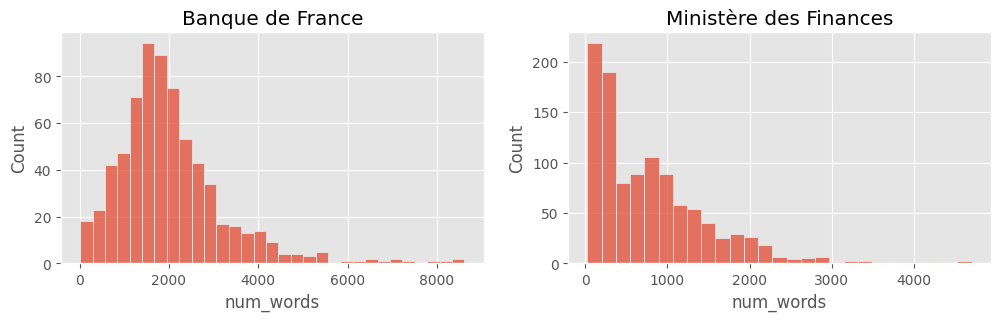

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
sns.histplot(jsons_data_BdF, x="num_words", ax=axes[0]).set_title("Banque de France")
sns.histplot(jsons_data_MF, x="num_words", ax=axes[1]).set_title("Ministère des Finances")
plt.show();

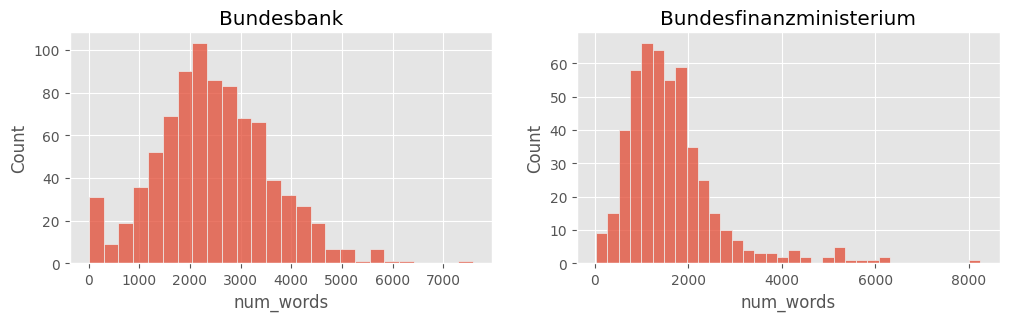

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax1 = sns.histplot(jsons_data_BB, x="num_words", ax=axes[0]).set_title("Bundesbank")
ax2 =sns.histplot(jsons_data_BMF, x="num_words", ax=axes[1]).set_title("Bundesfinanzministerium")
plt.show();

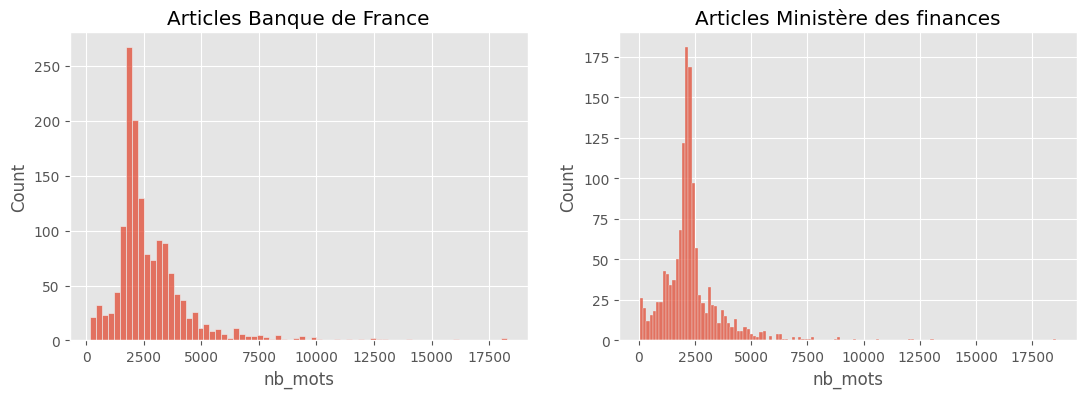

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
ax1  = sns.histplot(df_BdF, x="nb_mots", ax=axes[0]).set_title("Articles Banque de France")
ax2  = sns.histplot(df_MF,x="nb_mots", ax=axes[1]).set_title("Articles Ministère des finances")
plt.show();

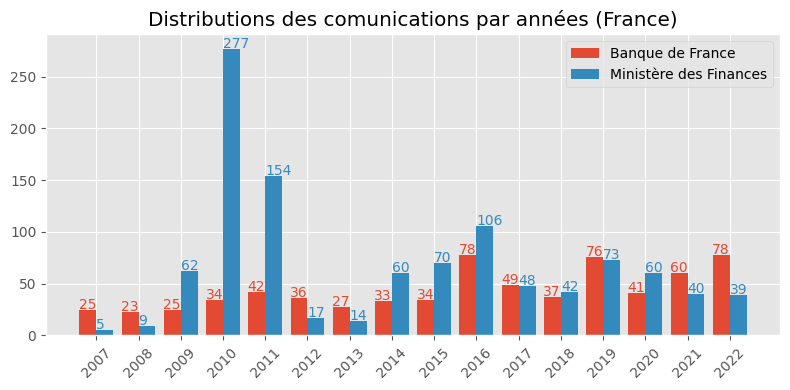

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
df1=jsons_data_BdF.groupby(jsons_data_BdF['DATE'].map(lambda x: x.year)).count()
df2=jsons_data_MF.groupby(jsons_data_MF['DATE'].map(lambda x: x.year)).count()
plt.bar(df1.index.tolist(), df1['DATE'], align='edge', width=-0.4, label='Banque de France')
plt.bar(df2.index.tolist(), df2['DATE'], align='edge', width=0.4, label='Ministère des Finances')
plt.title("Distributions des communications par années (France)")
for i, rows in df1.iterrows():
    plt.annotate(rows["DATE"], xy=(i, rows["TEXT"]+1), color="C0",rotation=0, ha="right")
for i, rows in df2.iterrows():
    plt.annotate(rows["DATE"], xy=(i, rows["TEXT"]+1), color="C1",rotation=0, ha="left")    
plt.xticks(df1.index.tolist(),rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

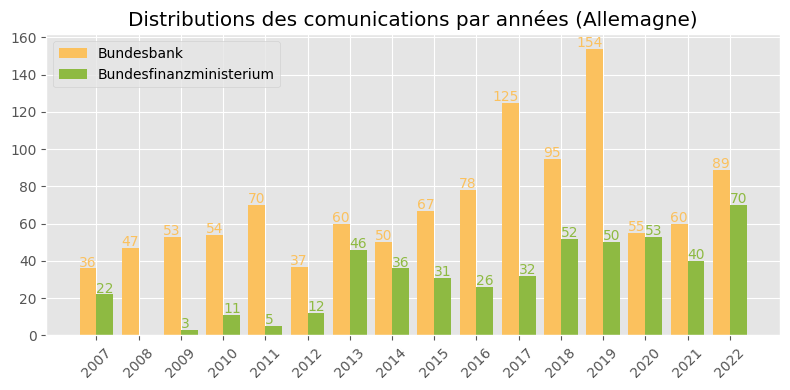

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
df1=jsons_data_BB.groupby(jsons_data_BB['DATE'].map(lambda x: x.year)).count()
df2=jsons_data_BMF.groupby(jsons_data_BMF['DATE'].map(lambda x: x.year)).count()
plt.bar(df1.index.tolist(), df1['DATE'], align='edge', color="C4", width=-0.4, label='Bundesbank')
plt.bar(df2.index.tolist(), df2['DATE'], align='edge', color="C5", width=0.4, label='Bundesfinanzministerium')
plt.title("Distributions des comunications par années (Allemagne)")
for i, rows in df1.iterrows():
    plt.annotate(rows["DATE"], xy=(i, rows["TEXT"]+1), color="C4",rotation=0, ha="right")
for i, rows in df2.iterrows():
    plt.annotate(rows["DATE"], xy=(i, rows["TEXT"]+1), color="C5",rotation=0, ha="left")    
plt.xticks(df1.index.tolist(),rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

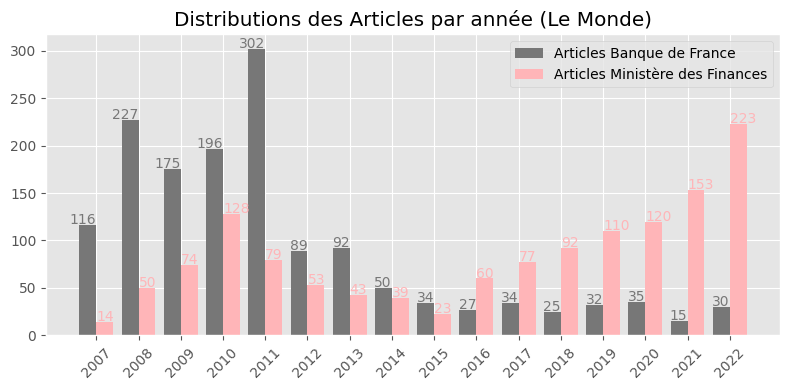

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
df1=df_BdF.groupby(df_BdF['article_date'].map(lambda x: x.year)).count()
df2=df_MF.groupby(df_MF['article_date'].map(lambda x: x.year)).count()
plt.bar(df1.index.tolist(), df1['article_date'], align='edge', color="C3", width=-0.4, label='Articles Banque de France')
plt.bar(df2.index.tolist(), df2['article_date'], align='edge', color="C6", width=0.4, label='Articles Ministère des Finances')
plt.title("Distributions des Articles par année (Le Monde)")
for i, rows in df1.iterrows():
    plt.annotate(rows["article_date"], xy=(i, rows["texte"]+1), color="C3",rotation=0, ha="right")
for i, rows in df2.iterrows():
    plt.annotate(rows["article_date"], xy=(i, rows["texte"]+1), color="C6",rotation=0, ha="left")    
plt.xticks(df1.index.tolist(),rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

On constate que le Ministère des Finances a tenu un nombre disproportionné de discours pendant la Crise de la dette dans la zone euro qui a débuté dans la foulée de la grande crise financière de 2007, c'est-à-dire de 2009 à 2011. Cela pourrait potentiellement fausser notre ensemble de données, car le contenu des discours peut tourner autour de questions liées à cette crise. Dans la suite, nous examinerons donc la distribution des mots, afin de voir si cette période est aberrante en termes de quantité de mots prononcés au cours de cette période.</br>

Les articles de presse qui parlent de la Banque de France étaient visiblement plus populaires durant la période du 2007-2011 avec un pic en 2011 et ça a considérablement diminué depuis : c'est probablement lié à la crise de la dette dans la zone Euro et ses conséquences économiques qui ont perduré jusqu'à l'année 2012.</br>

Par contre, les sujets liés au Ministère des Finances sont de plus en plus populaires et augmentent chaque année depuis 2018 pour atteindre un pic en 2022. En effet, les raisons sont plus politiques : la situation économique est influencée par la pénurie d'énergie dans le monde, causée en un premier temps par la forte reprise économique mondiale après la récession liée à la pandémie de Covid-19 de 2020 et amplifiée à partir de mars 2022 par l'invasion de l'Ukraine par la Russie

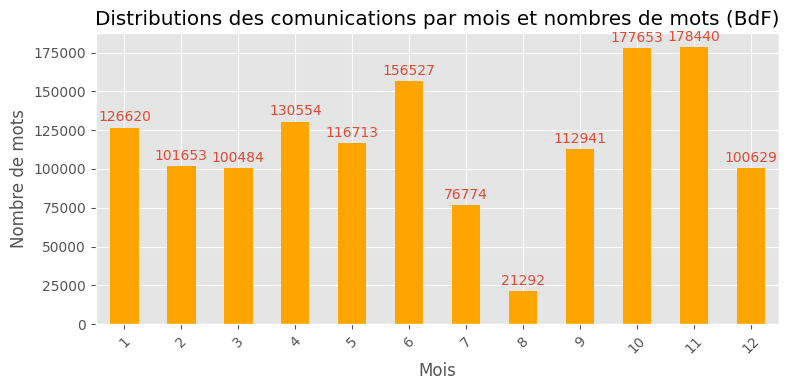

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
df1=jsons_data_BdF.groupby(jsons_data_BdF['DATE'].map(lambda x: x.month))["num_words"].sum()
df1.plot(kind='bar', color="Orange",title="Distributions des comunications par mois et nombres de mots (BdF)")
plt.xlabel("Mois")
plt.ylabel("Nombre de mots")
for i, rows in enumerate(df1):
    plt.annotate(rows, xy=(i, rows+4000), color="C0",rotation=+0,ha="center")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

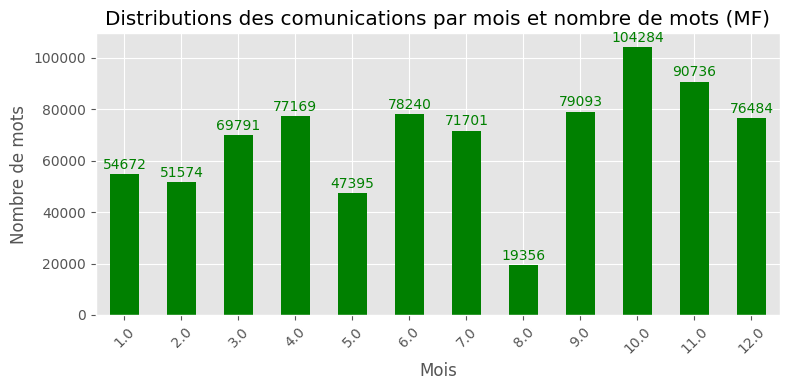

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
df1=jsons_data_MF.groupby(jsons_data_MF['DATE'].map(lambda x: x.month))["num_words"].sum()
df1.plot(kind='bar', color="Green",title="Distributions des comunications par mois et nombre de mots (MF)")
plt.xlabel("Mois")
plt.ylabel("Nombre de mots")
for i, rows in enumerate(df1):
    plt.annotate(rows, xy=(i, rows+2000),rotation=+0,ha="center",color="Green")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

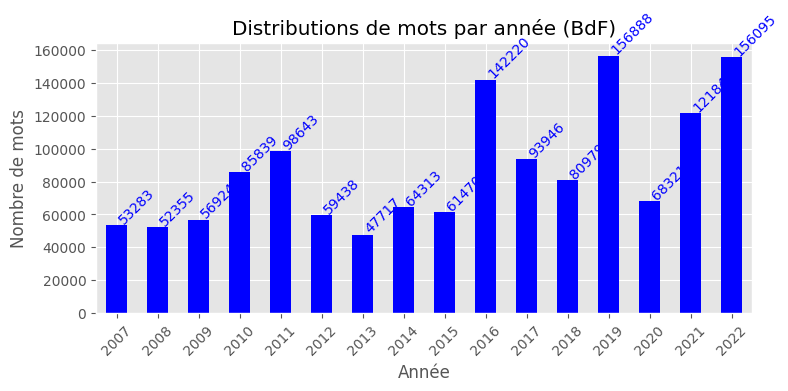

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
df1=jsons_data_BdF.groupby(jsons_data_BdF['DATE'].map(lambda x: x.year))["num_words"].sum()
df1.plot(kind='bar',color="Blue", title="Distributions de mots par année (BdF)")
plt.xlabel("Année")
plt.ylabel("Nombre de mots")
for i, rows in enumerate(df1):
    plt.annotate(rows, xy=(i, rows+1000),rotation=+45,ha="left",color="Blue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

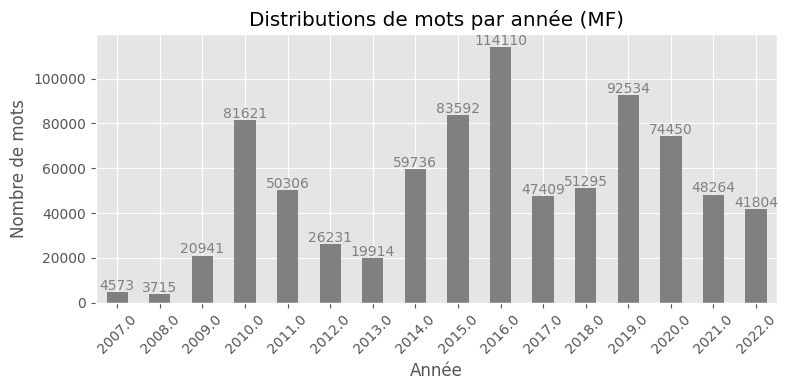

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
df1=jsons_data_MF.groupby(jsons_data_MF['DATE'].map(lambda x: x.year))["num_words"].sum()
df1.plot(kind='bar',color="Grey", title="Distributions de mots par année (MF)")
plt.xlabel("Année")
plt.ylabel("Nombre de mots")
for i, rows in enumerate(df1):
    plt.annotate(rows, xy=(i, rows+1000),rotation=+0,ha="center",color="Grey")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En examinant la distribution des mots, nous pouvons nuancer notre analyse préalable et observer que si les discours ont effectivement été plus nombreux pendant la crise de la dette européenne, ces discours n'ont pas fourni plus de contenu textuel. En fait, en termes de répartition des mots, le Ministère des Finances communique davantage ces derniers temps qu'il ne le faisait pendant la crise.

## Mots populaires

In [ ]:
# Définition d'une fonction pour filtrer les mots unique sans stopwords
def popular_words(df,stopwords):
    wordcount = collections.defaultdict(int)
    for txt in df['Processed TEXT']:
      for word in txt.split(" "):
        if word not in stopwords:
          wordcount[word] += 1
    mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)  
    return mc

In [ ]:
def plot_pop(df,nwords,institution):
    df[:nwords].plot(x="Words",y="Frequency",kind='bar',color="Blue", title=f"Fréquence des mots {institution}",figsize=(10,6))
    plt.xlabel("Mots")
    plt.ylabel("Fréquence")
    for i, rows in df[:nwords].iterrows():
        plt.annotate(rows["Frequency"], xy=(i, rows["Frequency"]+100),rotation=+45,ha="left",color="Blue")
    plt.xticks(rotation=45,ha="right", fontweight="bold")
    plt.tight_layout()
    plt.show()

### France

In [ ]:
pop_BdF=popular_words(jsons_data_BdF,stopwords_fr)
pop_MF=popular_words(jsons_data_MF,stopwords_fr)
df_pop_BdF=pd.DataFrame(pop_BdF,columns=["Words","Frequency"])
df_pop_MF=pd.DataFrame(pop_MF,columns=["Words","Frequency"])

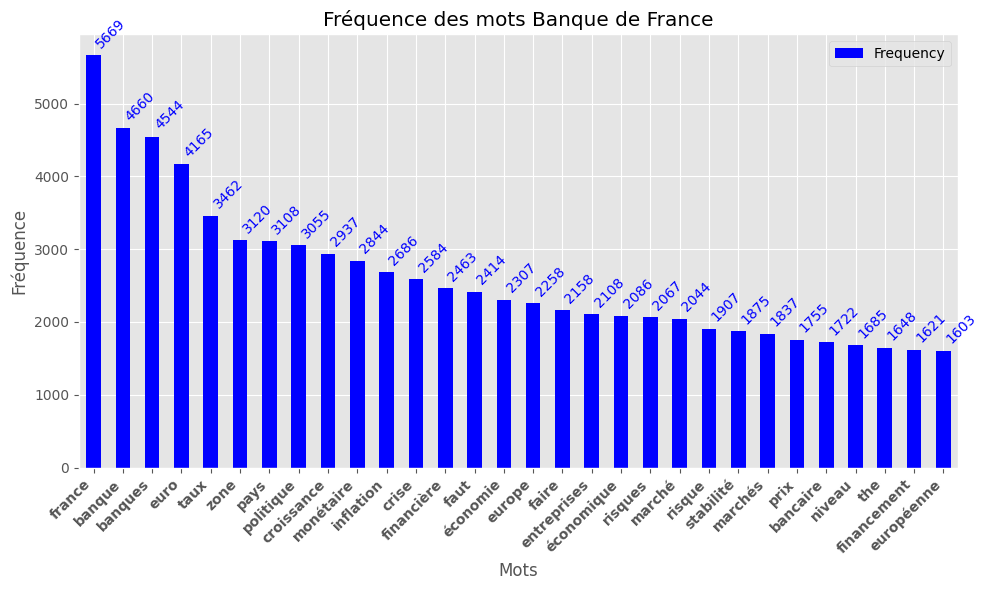

In [ ]:
plot_pop(df_pop_BdF,30,"Banque de France") 

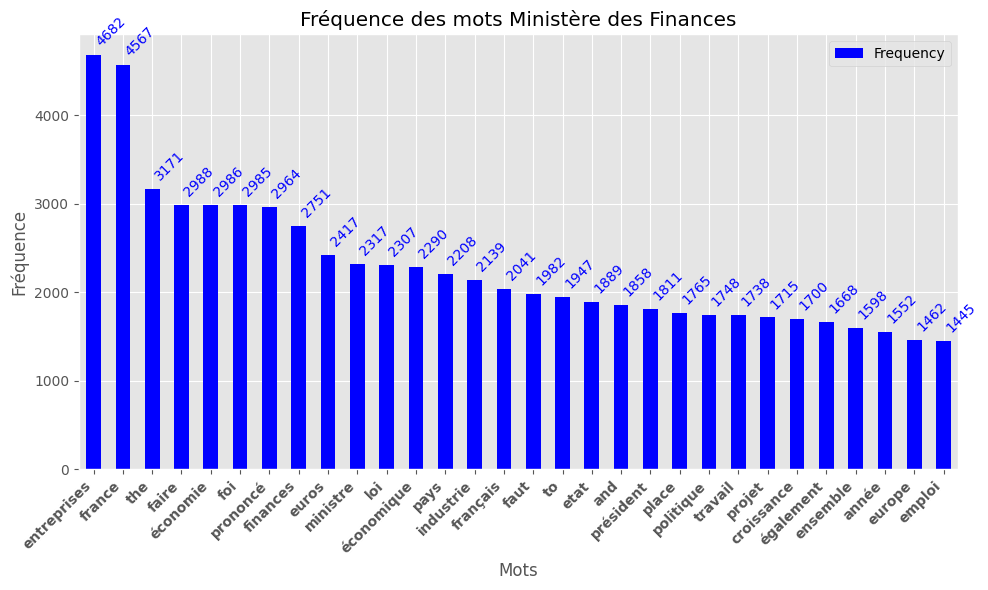

In [ ]:
plot_pop(df_pop_MF,30,"Ministère des Finances") 

In [ ]:
cent_pop_MF = df_pop_MF['Words'].iloc[:100]
cent_pop_BdF = df_pop_BdF['Words'].iloc[:100]
cent_pop_all = pd.concat([cent_pop_MF,cent_pop_BdF], ignore_index=True)
u = (cent_pop_all.nunique()/200)*100
print(f"{u}% des 100 mots les plus populaires sont partagés entre la Banque de France et le Ministère des Finances.")

75.0% des 100 mots les plus populaires sont partagés entre la Banque de France et le Ministère des Finances.


Les mots les plus populaires dans les articles.

In [ ]:
df_BdF = df_BdF.rename(columns={"Processed_texte" : 'Processed TEXT'})
pop_article_BdF=popular_words(df_BdF,stopwords_fr)
df_pop_article_BdF=pd.DataFrame(pop_article_BdF,columns=["Words","Frequency"])

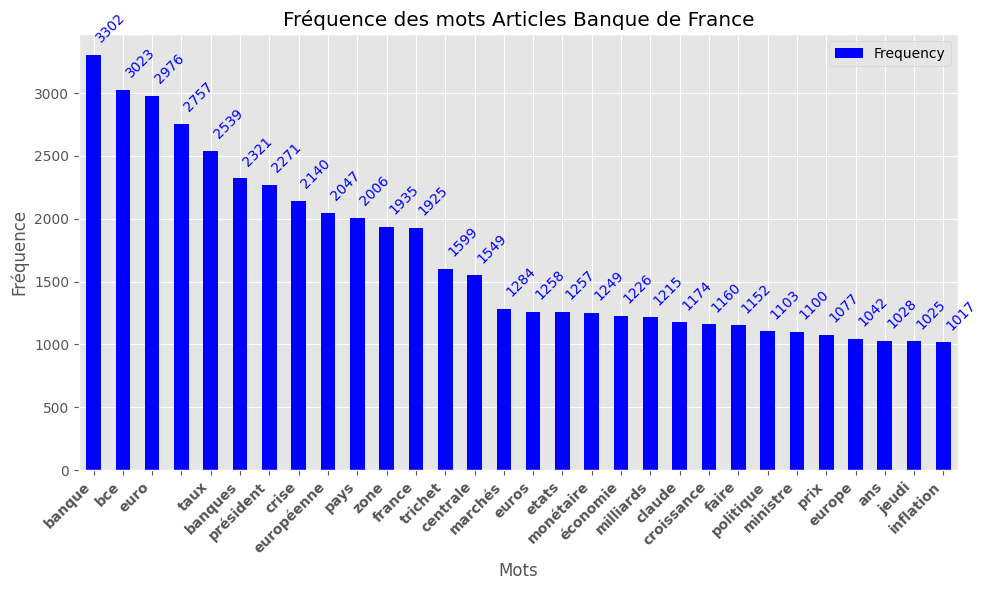

In [ ]:
plot_pop(df_pop_article_BdF,30,"Articles Banque de France")

In [ ]:
df_MF = df_MF.rename(columns={"Processed_texte" : 'Processed TEXT'})
pop_article_MF=popular_words(df_MF,stopwords_fr)
df_pop_article_MF =pd.DataFrame(pop_article_MF,columns=["Words","Frequency"])

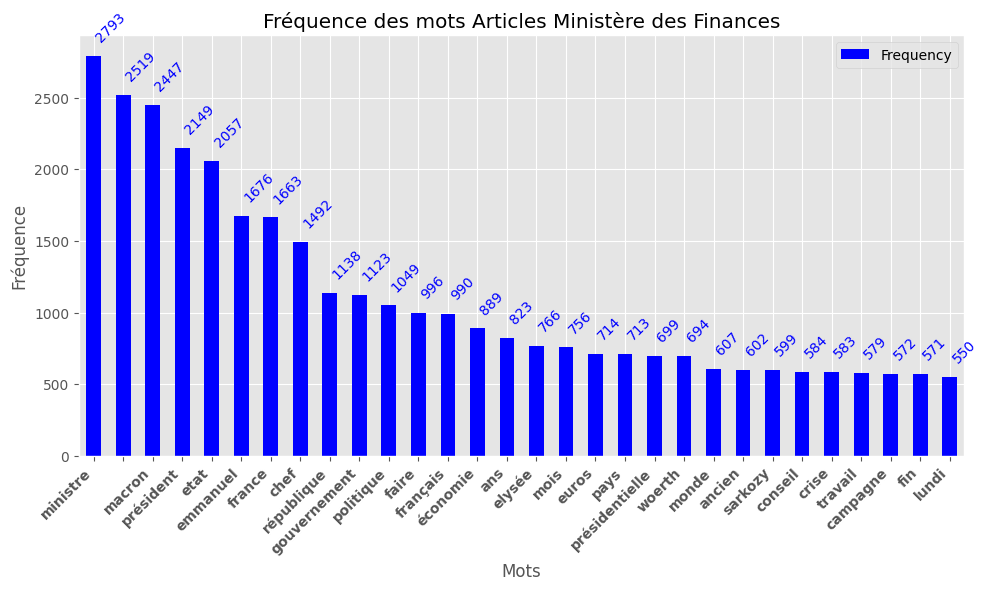

In [ ]:
plot_pop(df_pop_article_MF,30,"Articles Ministère des Finances")

### Allemagne

In [ ]:
pop_BB=popular_words(jsons_data_BB,stopwords_de)
df_pop_BB=pd.DataFrame(pop_BB,columns=["Words","Frequency"])

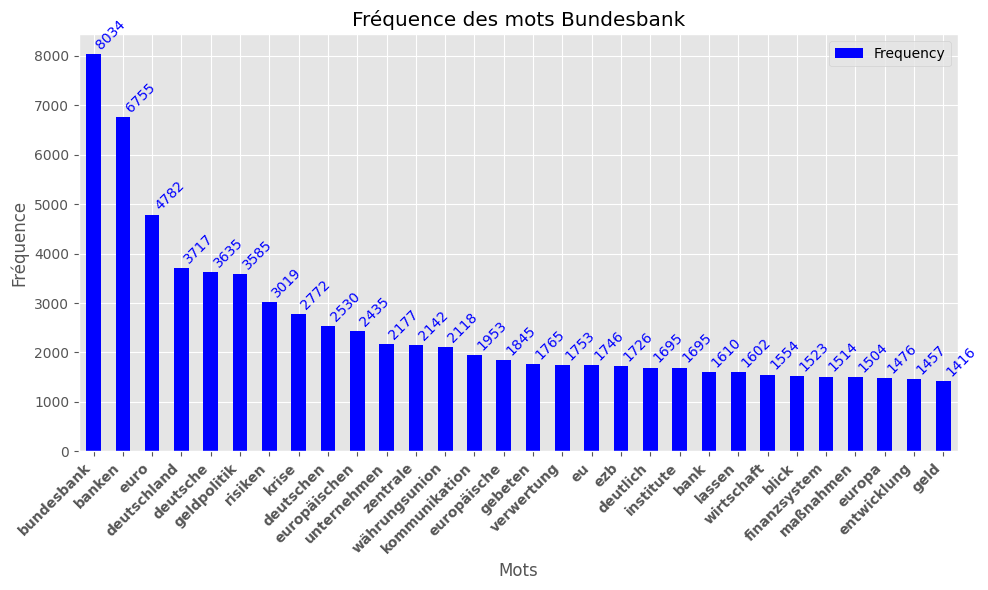

In [ ]:
plot_pop(df_pop_BB,30,"Bundesbank") 

In [ ]:
pop_BMF=popular_words(jsons_data_BMF,stopwords_de)
df_pop_BMF=pd.DataFrame(pop_BMF,columns=["Words","Frequency"])

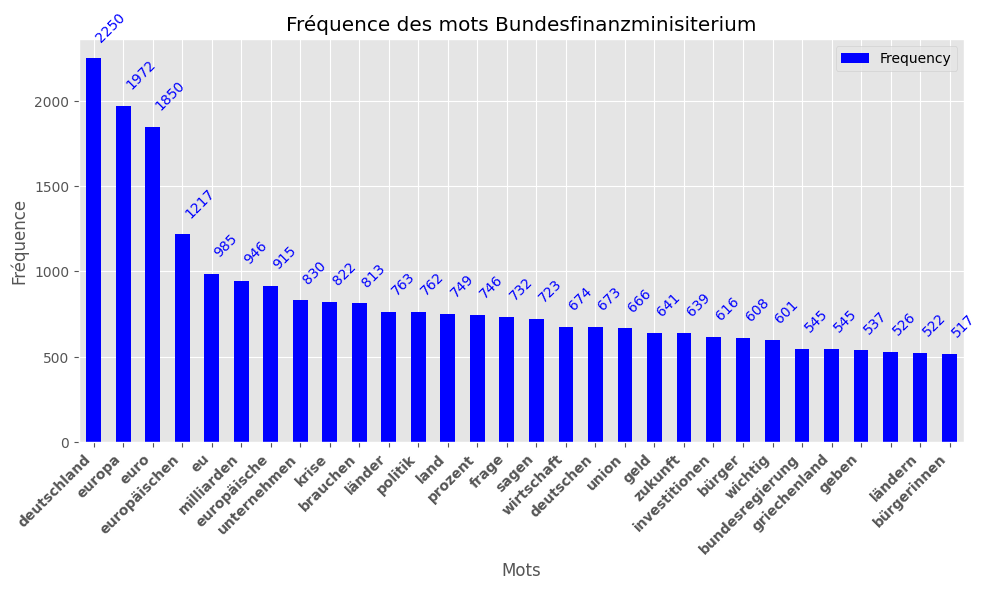

In [ ]:
plot_pop(df_pop_BMF,30,"Bundesfinanzminisiterium") 

In [ ]:
cent_pop_BMF = df_pop_BMF['Words'].iloc[:100]
cent_pop_BB = df_pop_BB['Words'].iloc[:100]
cent_pop_all = pd.concat([cent_pop_BMF,cent_pop_BB], ignore_index=True)
u = (cent_pop_all.nunique()/200)*100
print(f"{u}% des 100 mots les plus populaires sont partagés entre la Bundesbank et le Bundesfinanzministerium.")

81.0% des 100 mots les plus populaires sont partagés entre la Bundesbank et le Bundesfinanzministerium.


## Distribution des mots par intervenant

### France

In [ ]:
# Effacer les textes sans locuteur 
BdF_authors = jsons_data_BdF.dropna(subset = ['AUTHOR'])
BdF_authors = BdF_authors[BdF_authors['AUTHOR'].str.len()>2]
MF_authors = jsons_data_MF.dropna(subset = ['AUTHOR'])
MF_authors = MF_authors[MF_authors['AUTHOR'].str.len()>2]
MF_authors = MF_authors.replace(to_replace='None', value=np.nan).dropna()

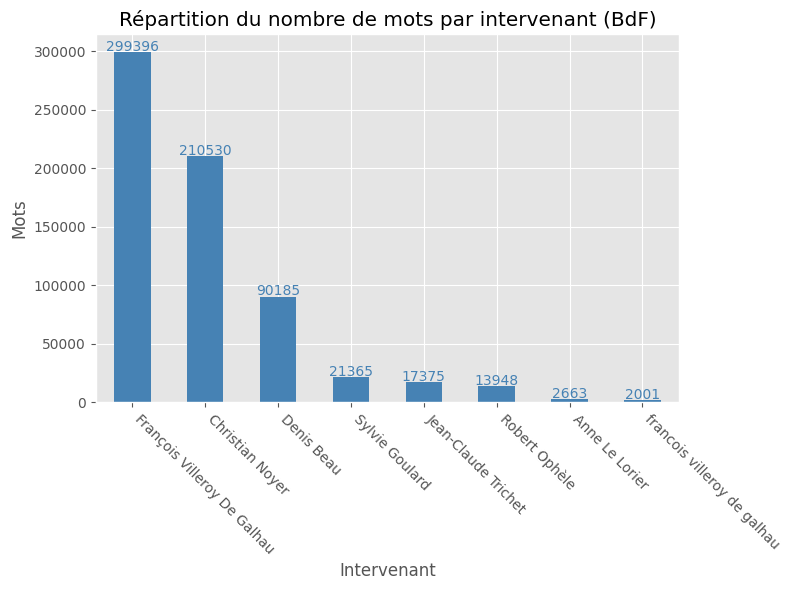

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
df1=BdF_authors.groupby(jsons_data_BdF['AUTHOR'])["num_words"].sum().sort_values(ascending=False)
df1.plot(kind='bar',color="Steelblue", title="Répartition du nombre de mots par intervenant (BdF)")
plt.xlabel("Intervenant")
plt.ylabel("Mots")
for i, rows in enumerate(df1):
    plt.annotate(rows, xy=(i, rows+1000),rotation=0,ha="center",color="Steelblue")
plt.xticks(rotation=-45, ha="left")
plt.tight_layout()
plt.show()

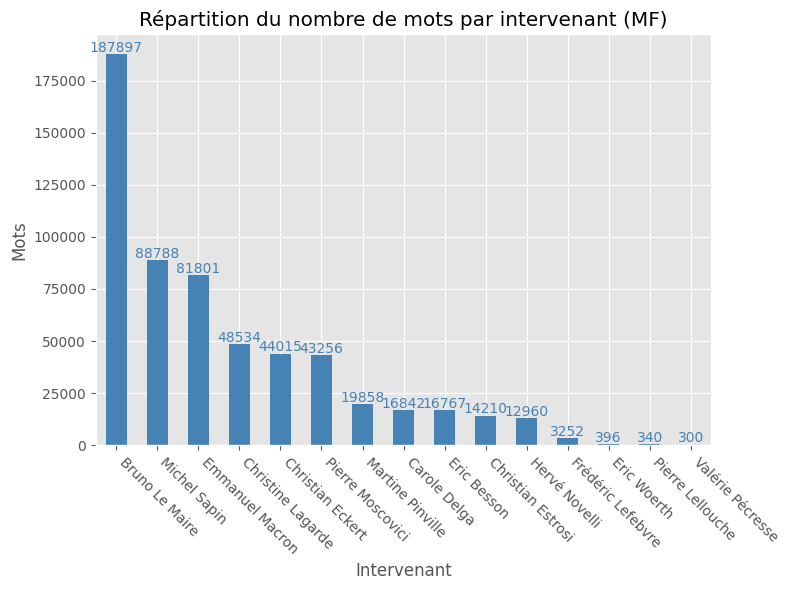

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
df1=MF_authors.groupby(MF_authors['AUTHOR'])["num_words"].sum().sort_values(ascending=False)
df1.plot(kind='bar',color="Steelblue", title="Répartition du nombre de mots par intervenant (MF)")
plt.xlabel("Intervenant")
plt.ylabel("Mots")
for i, rows in enumerate(df1):
    plt.annotate(rows, xy=(i, rows+1000),rotation=0,ha="center",color="Steelblue")
plt.xticks(rotation=-45, ha="left")
plt.tight_layout()
plt.show()

### Allemagne

In [ ]:
BB_authors = jsons_data_BB.dropna(subset = ['AUTHOR'])
BB_authors = BB_authors[BB_authors['AUTHOR'].str.len()>2]

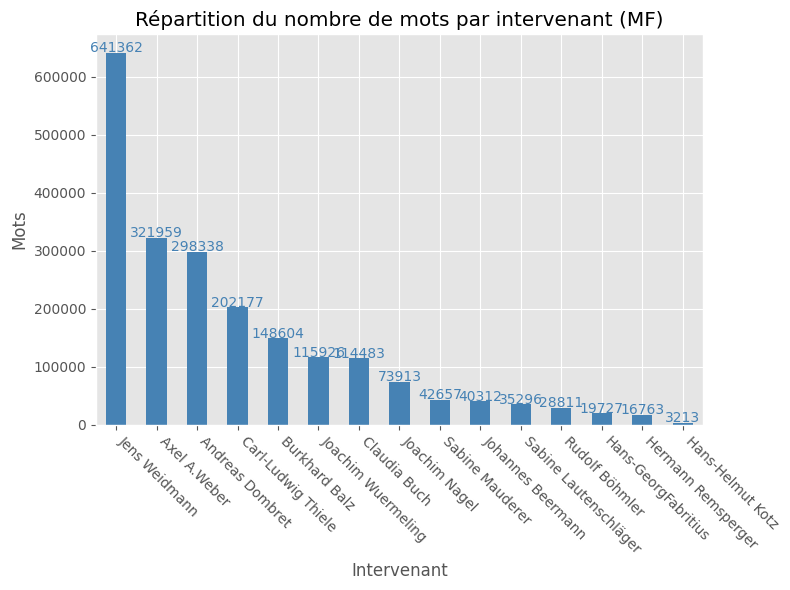

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
df1=BB_authors.groupby(BB_authors['AUTHOR'])["num_words"].sum().sort_values(ascending=False)
df1.plot(kind='bar',color="Steelblue", title="Répartition du nombre de mots par intervenant (BB)")
plt.xlabel("Intervenant")
plt.ylabel("Mots")
for i, rows in enumerate(df1):
    plt.annotate(rows, xy=(i, rows+1000),rotation=45,ha="center",color="Steelblue")
plt.xticks(rotation=-45, ha="left")
plt.tight_layout()
plt.show()

In [ ]:
BMF_authors = jsons_data_BMF.dropna(subset = ['AUTHOR'])
BMF_authors = BMF_authors[BMF_authors['AUTHOR'].str.len()>4]

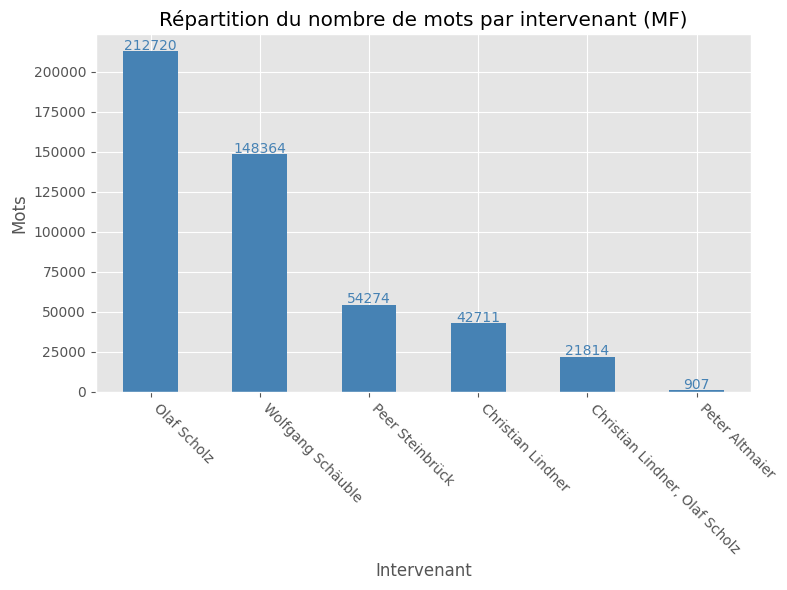

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
df1=BMF_authors.groupby(BMF_authors['AUTHOR'])["num_words"].sum().sort_values(ascending=False)
df1.plot(kind='bar',color="Steelblue", title="Répartition du nombre de mots par intervenant (BMF)")
plt.xlabel("Intervenant")
plt.ylabel("Mots")
for i, rows in enumerate(df1):
    plt.annotate(rows, xy=(i, rows+1000),rotation=0,ha="center",color="Steelblue")
plt.xticks(rotation=-45, ha="left")
plt.tight_layout()
plt.show()

# Statisitiques données macro

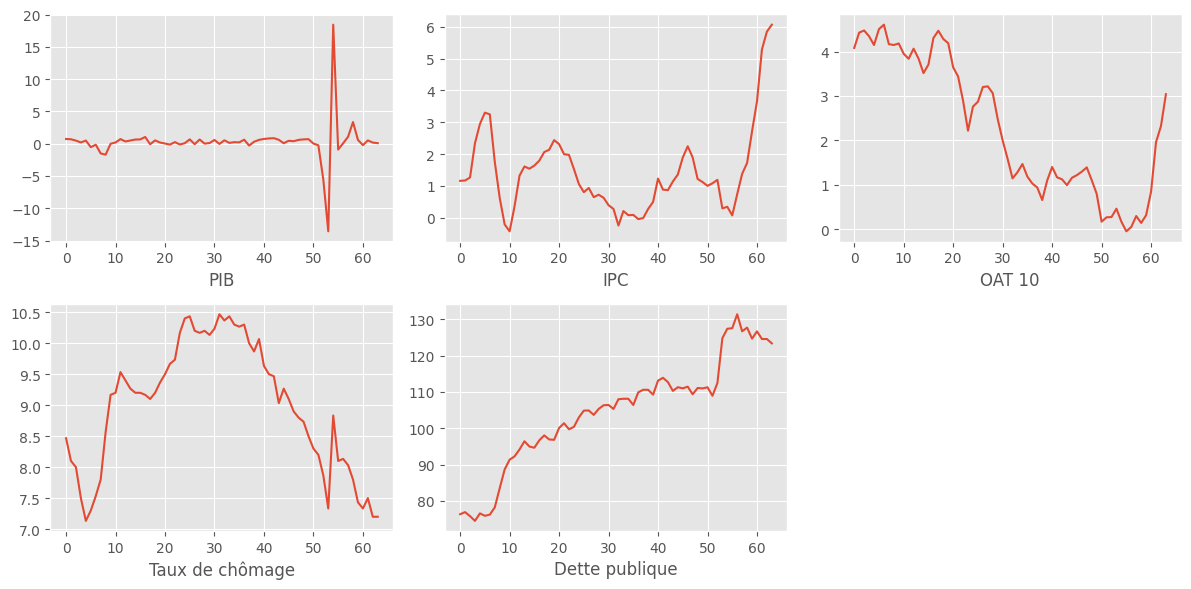

In [ ]:
#Données macroéconomiques France 
plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
df_macro_fr.PIB.plot(x=df_macro_fr.TIME) 
plt.xlabel('PIB')
plt.subplot(2,3,2)
df_macro_fr.IPC.plot(x=df_macro_fr.TIME)
plt.xlabel('IPC')
plt.subplot(2,3,3)
df_macro_fr.LONG_RATE.plot(x=df_macro_fr.TIME)
plt.xlabel('OAT 10')
plt.subplot(2,3,4)
df_macro_fr.TAUX_DE_CHÔMAGE.plot(x=df_macro_fr.TIME)
plt.xlabel('Taux de chômage')
plt.subplot(2,3,5)
df_macro_fr.DETTE_PUBLIQUE.plot(x=df_macro_fr.TIME)
plt.xlabel('Dette publique')
plt.tight_layout();

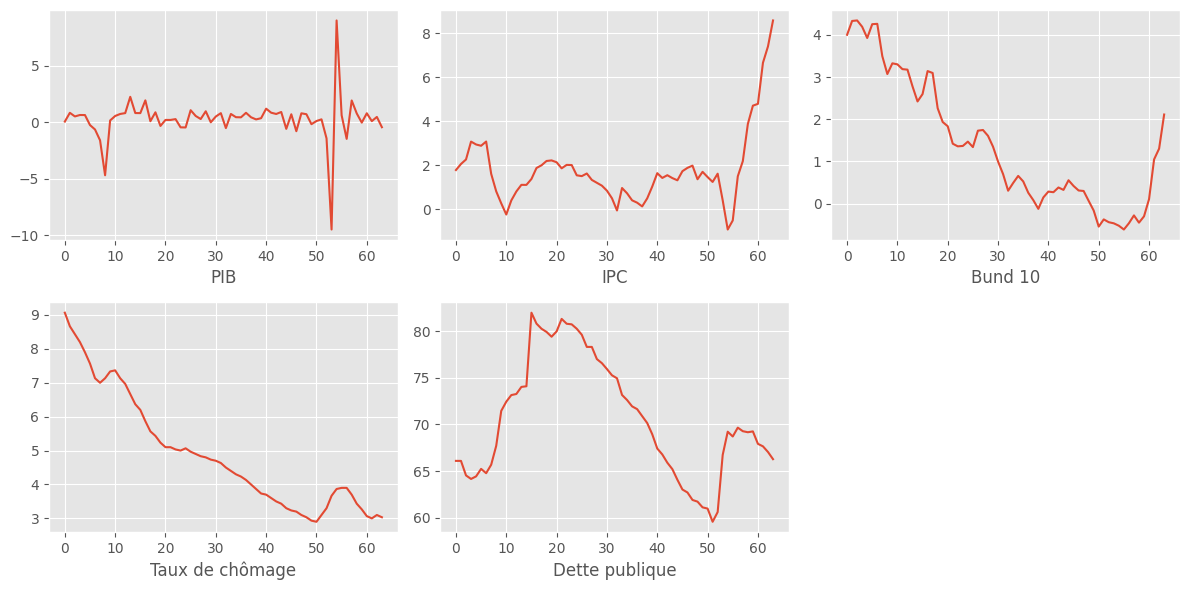

In [ ]:
# Données macroéconomiques Allemagne
plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
df_macro_de.PIB.plot(x=df_macro_de.TIME) 
plt.xlabel('PIB')
plt.subplot(2,3,2)
df_macro_de.IPC.plot(x=df_macro_de.TIME)
plt.xlabel('IPC')
plt.subplot(2,3,3)
df_macro_de.LONG_RATE.plot(x=df_macro_de.TIME)
plt.xlabel('Bund 10')
plt.subplot(2,3,4)
df_macro_de.TAUX_DE_CHÔMAGE.plot(x=df_macro_de.TIME)
plt.xlabel('Taux de chômage')
plt.subplot(2,3,5)
df_macro_de.DETTE_PUBLIQUE.plot(x=df_macro_de.TIME)
plt.xlabel('Dette publique')
plt.tight_layout();

# Flesch-Kincaid Test

Les tests de lisibilité Flesch-Kincaid sont des examens de lisibilité conçus pour indiquer la difficulté de compréhension d'un texte. Dans l'examen de facilité de lecture de Flesch, des scores élevés indiquent des documents plus faciles à lire ; des nombres plus faibles indiquent des passages plus difficiles à lire. La formule pour cet examen est comme suit : </br> 

$\ 206.835 - 1.015 \Big(\dfrac{\text{mots totaux}}{\text{phrases totales}}\Big) - 84.6 \Big(\dfrac{\text{syllables tales}}{\text{mots totaux}}\Big)$ </br> 

Ce type d'analyse peut nous donner des informations pertinentes sur la similarité des textes en examinant le degré de difficulté de compréhension des textes. 

In [ ]:
# Création d'une pipeline pour procéder les textes français
nlp_fr=spacy.load('fr_core_news_md', disable=["parser", "tagger"])
nlp_fr.add_pipe(nlp_fr.create_pipe('sentencizer'))
read=Readability()
nlp_fr.add_pipe(read, last=True)

In [ ]:
F_K_r_test = lambda txt,nlp: nlp(txt)._.flesch_kincaid_reading_ease
def readability(data,nlp) :
     data['readability score']=data['TEXT'].apply(lambda x:F_K_r_test(x,nlp))

In [ ]:
readability(jsons_data_BdF,nlp_fr)
readability(jsons_data_MF,nlp_fr)

In [ ]:
jsons_data_BdF["readability score"]=jsons_data_BdF["readability score"].map(lambda x: int(abs(x)))
df_fk_en=jsons_data_BdF[["DATE","readability score"]].groupby(jsons_data_BdF['DATE'].map(lambda x: x.year)).mean(numeric_only=False)
df_fk_en["readability score"]=df_fk_en["readability score"].map(lambda x: int(x)).astype('float')
fig = px.bar(df_fk_en,y=df_fk_en.index.tolist(),x="readability score",orientation='h',text='readability score',
             title= "Score moyen de lisibilité BdF",
             width=600, height=500)
fig.update_layout(xaxis = {'showgrid': True ,'visible': False},yaxis={'showgrid': True,'title':'Année','tickmode':"linear"})
fig.update_traces( textposition='outside')
fig.show();

In [ ]:
jsons_data_MF["readability score"]=jsons_data_MF["readability score"].map(lambda x: int(abs(x)))
df_fk_MF=jsons_data_MF[["DATE","readability score"]].groupby(jsons_data_MF['DATE'].map(lambda x: x.year)).mean(numeric_only=False)
df_fk_MF["readability score"]=df_fk_MF["readability score"].map(lambda x: int(x)).astype('float')
fig = px.bar(df_fk_MF,y=df_fk_MF.index.tolist(),x="readability score",orientation='h',text='readability score',
             title= "Score moyen de lisibilité MF",
             width=600, height=500)
fig.update_layout(xaxis = {'showgrid': True ,'visible': False},yaxis={'showgrid': True,'title':'Année','tickmode':"linear"})
fig.update_traces( textposition='outside')
fig.show()

In [ ]:
# Création d'une pipeline pour procéder les textes allemand
nlp_de=spacy.load('de_core_news_md', disable=["parser", "tagger"])
nlp_de.add_pipe(nlp_de.create_pipe('sentencizer'))
read=Readability()
nlp_de.add_pipe(read, last=True)

In [ ]:
readability(jsons_data_BB,nlp_de)

In [ ]:
jsons_data_BB["readability score"]=jsons_data_BB["readability score"].map(lambda x: int(abs(x)))
df_fk_BB=jsons_data_BB[["DATE","readability score"]].groupby(jsons_data_BB['DATE'].map(lambda x: x.year)).mean(numeric_only=False)
df_fk_BB["readability score"]=df_fk_BB["readability score"].map(lambda x: int(x)).astype('float')
fig = px.bar(df_fk_BB,y=df_fk_BB.index.tolist(),x="readability score",orientation='h',text='readability score',
             title= "Score moyen de lisibilité Bundesbank",
             width=600, height=500)
fig.update_layout(xaxis = {'showgrid': True ,'visible': False},yaxis={'showgrid': True,'title':'Année','tickmode':"linear"})
fig.update_traces( textposition='outside')
fig.show()

In [ ]:
readability(jsons_data_BMF,nlp_de)

In [ ]:
jsons_data_BMF["readability score"]=jsons_data_BMF["readability score"].map(lambda x: int(abs(x)))
df_fk_BMF=jsons_data_BMF[["DATE","readability score"]].groupby(jsons_data_BMF['DATE'].map(lambda x: x.year)).mean(numeric_only=False)
df_fk_BMF["readability score"]=df_fk_BMF["readability score"].map(lambda x: int(x)).astype('float')
fig = px.bar(df_fk_BMF,y=df_fk_BMF.index.tolist(),x="readability score",orientation='h',text='readability score',
             title= "Score moyen de lisibilité Bundesbank",
             width=600, height=500)
fig.update_layout(xaxis = {'showgrid': True ,'visible': False},yaxis={'showgrid': True,'title':'Année','tickmode':"linear"})
fig.update_traces( textposition='outside')
fig.show()

Les textes de la Banque de France et du Ministère deviennent de plus en plus "facile" à comprendre au fur du temps. Un score entre 60.0–50.0 signifie un niveau de lisibilité "Seconde vers Terminale" et la note "plutôt difficile à lire". Un score entre 50.0–30.0 signifie un niveau de lisibilité "Université ou Grande Ecole" et la note "difficile à lire. Même si cette analyse met en évidence une première similitude, il convient d'être prudent. Cette métrique ne nous dit rien sur le contenu ou le contexte, par exemple un texte scientifique et un roman de Proust peuvent tous deux être difficiles mais n'avoir que peu de choses en commun. 

# TF-IDF Vectorization



Le TF-IDF est une méthode de pondération statistique qui permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. La fréquence des termes, $\text{tf}({t,d})$, est la fréquence relative du terme $\textit{t}$ dans le document $\textit{d}$,</br> 

$\text{tf}({t,d}) = \dfrac{f_{t,d}}{\sum_{t^{'}\in d} f_{t^{'},d}}$

où $\mathit{f_{t,d}}$ est le nombre d'un terme dans un document, c'est-à-dire le nombre de fois que le terme $\mathit{t}$ apparaît dans le document $\textit{d}$.</br> 

Cette analyse nous permettra d'obtenir une première réponse, très basique, à la question de la similitude de nos textes en trouvant simplement certains thèmes qui peuvent ou non se ressembler.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Définition d'une fonction pour véctorizer nos données
def TF_IDF(data,stopw):   
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2,stop_words=list(stopw))
    dtm=tfidf.fit_transform(data['Processed TEXT'])
    return tfidf,dtm

In [ ]:
# Application de la fonction aux données de la Banque de France 
vectorizer_BdF,dtm_BdF=TF_IDF(jsons_data_BdF,stopwords_fr)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.



In [ ]:
print(f"Nous avons un vocabulaire de {len(vectorizer_BdF.vocabulary_) } mots unique pour les discours de la BdF.")
print(f"Le document term matrix est {dtm_BdF.todense().shape}")

Nous avons un vocabulaire de 17204 mots unique pour les discours de la BdF.
Le document term matrix est (686, 17204)


In [ ]:
# Application de la fonction aux données du Ministère 
vectorizer_MF,dtm_MF=TF_IDF(jsons_data_MF,stopwords_fr)

In [ ]:
print(f"Nous avons un vocabulaire de {len(vectorizer_MF.vocabulary_) } mots unique pour les discours de la BdF.")
print(f"Le document term matrix est {dtm_MF.todense().shape}")

Nous avons un vocabulaire de 18379 mots unique pour les discours de la BdF.
Le document term matrix est (1052, 18379)


In [ ]:
# Application de la fonction aux données de la Bundesbank 
vectorizer_BB,dtm_BB=TF_IDF(jsons_data_BB,stopwords_de)

In [ ]:
print(f"Nous avons un vocabulaire de {len(vectorizer_BB.vocabulary_) } mots unique pour les discours de la Bundesbank.")
print(f"Le document term matrix est {dtm_BB.todense().shape}")

Nous avons un vocabulaire de 40380 mots unique pour les discours de la Bundesbank.
Le document term matrix est (854, 40380)


In [ ]:
# Application de la fonction aux données de la Bundesfinanzministerium 
vectorizer_BMF,dtm_BMF=TF_IDF(jsons_data_BMF,stopwords_de)

In [ ]:
print(f"Nous avons un vocabulaire de {len(vectorizer_BMF.vocabulary_) } mots unique pour les discours de le Bundesfinanzministerium.")
print(f"Le document term matrix est {dtm_BMF.todense().shape}")

Nous avons un vocabulaire de 18645 mots unique pour les discours de le Bundesfinanzministerium.
Le document term matrix est (489, 18645)


## Mots clés

### France

In [ ]:
tf_idf_score_BdF = pd.DataFrame(dtm_BdF.toarray().sum(axis=0),index= vectorizer_BdF.get_feature_names_out()).sort_values(by=0)

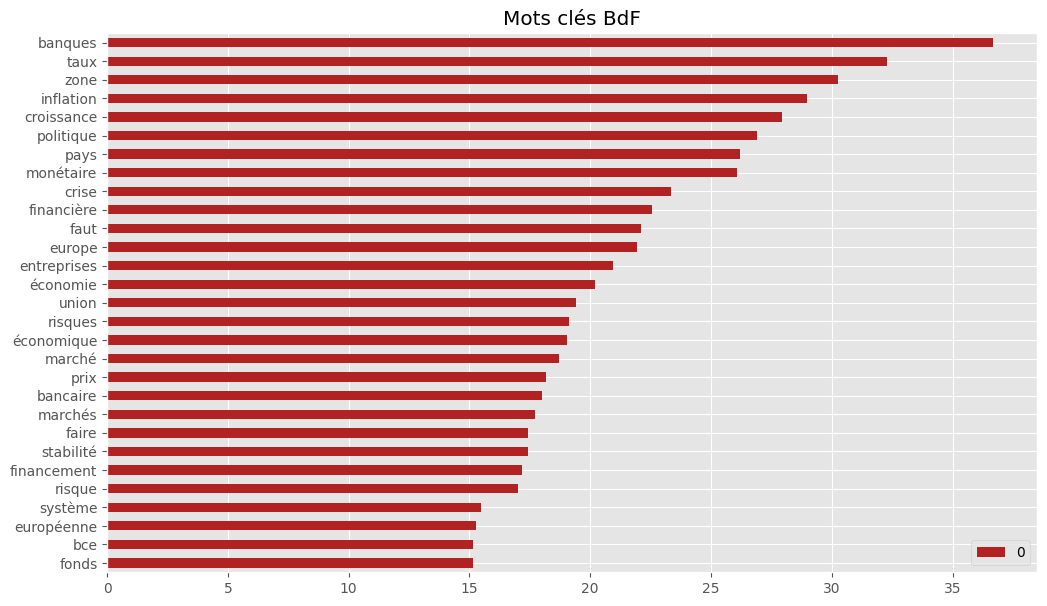

In [ ]:
tf_idf_score_BdF[-30:-1:1].plot(kind='barh', color='firebrick', figsize = (12, 7), title='Mots clés BdF');

In [ ]:
tf_idf_score_MF = pd.DataFrame(dtm_MF.toarray().sum(axis=0),index= vectorizer_MF.get_feature_names_out()).sort_values(by=0)

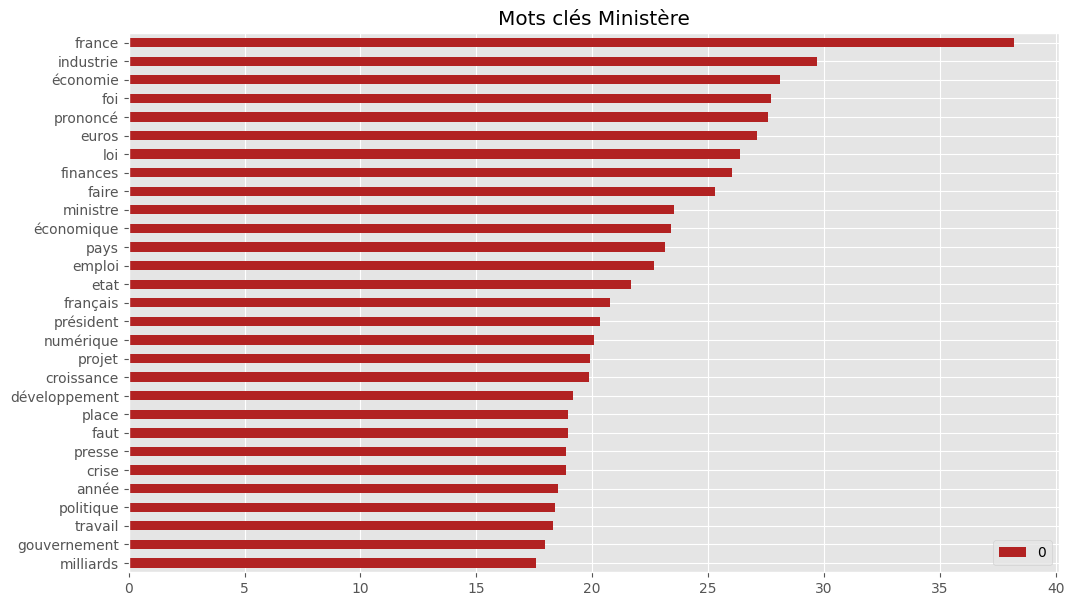

In [ ]:
tf_idf_score_MF[-30:-1:1].plot(kind='barh', color='firebrick', figsize = (12, 7), title='Mots clés Ministère');

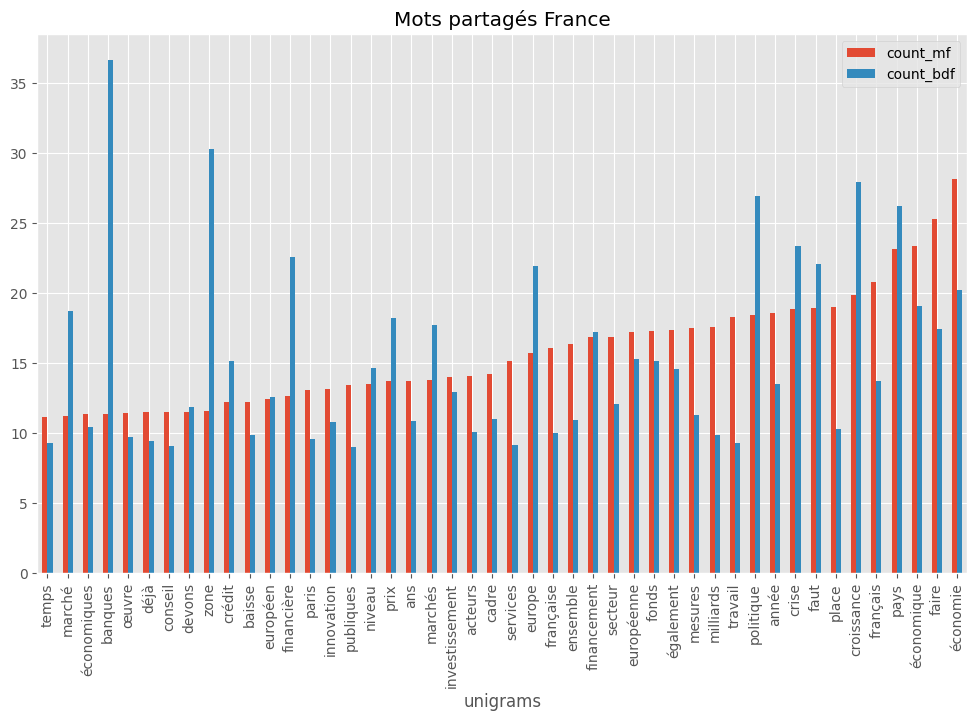

In [ ]:
cents_mots_mf = tf_idf_score_MF[-100:-1:1].reset_index()
cents_mots_mf.columns =['unigrams', 'count_mf']
cents_mots_bdf = tf_idf_score_BdF[-100:-1:1].reset_index()
cents_mots_bdf.columns =['unigrams', 'count_bdf']

mots_partage = pd.merge(cents_mots_mf , cents_mots_bdf, on=["unigrams"], how='inner')
mots_partage
mots_partage.plot(kind='bar', x='unigrams', figsize = (12, 7), title='Mots partagés France');

### Allemagne

In [ ]:
tf_idf_score_BB = pd.DataFrame(dtm_BB.toarray().sum(axis=0),index= vectorizer_BB.get_feature_names_out()).sort_values(by=0)

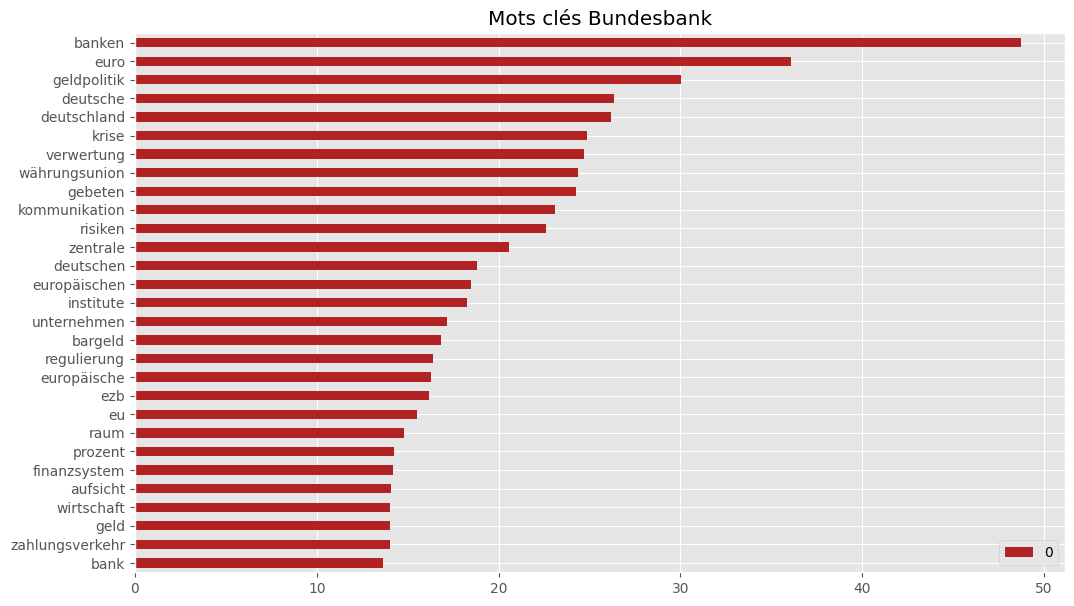

In [ ]:
tf_idf_score_BB[-30:-1:1].plot(kind='barh', color='firebrick', figsize = (12, 7), title='Mots clés Bundesbank');

In [ ]:
tf_idf_score_BMF = pd.DataFrame(dtm_BMF.toarray().sum(axis=0),index= vectorizer_BMF.get_feature_names_out()).sort_values(by=0)

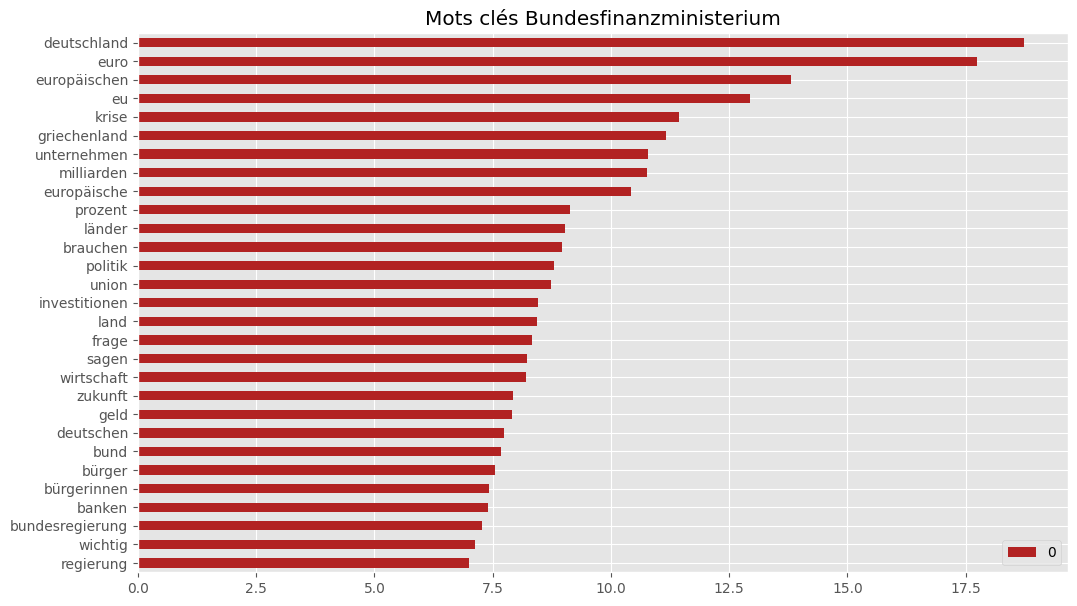

In [ ]:
tf_idf_score_BMF[-30:-1:1].plot(kind='barh', color='firebrick', figsize = (12, 7), title='Mots clés Bundesfinanzministerium');

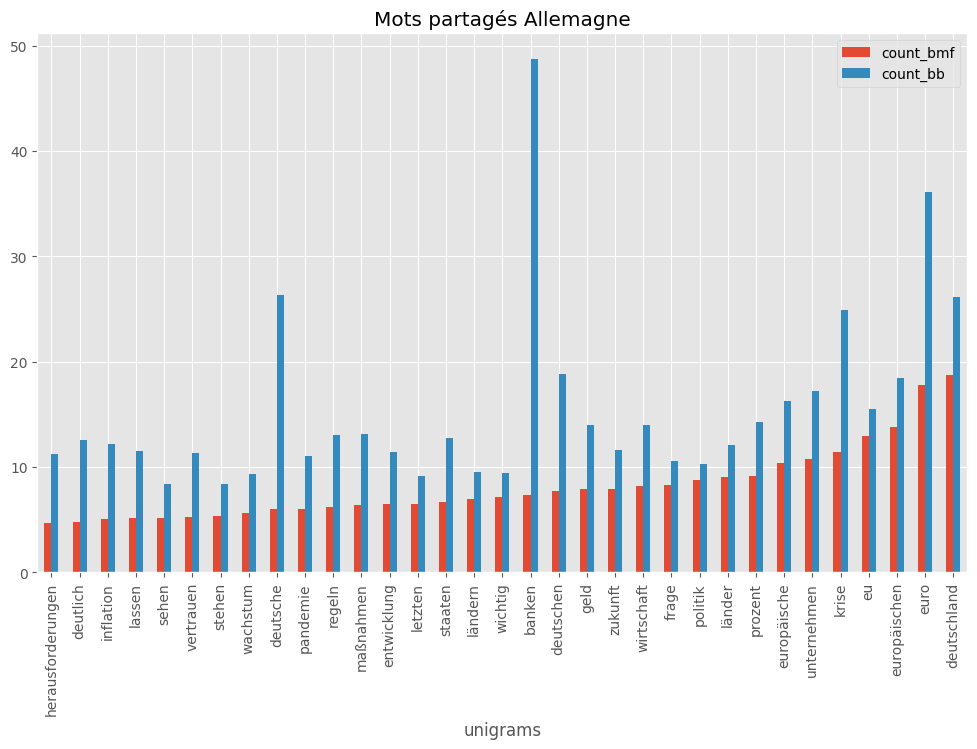

In [ ]:
cents_mots_bmf = tf_idf_score_BMF[-100:-1:1].reset_index()
cents_mots_bmf.columns =['unigrams', 'count_bmf']
cents_mots_bb = tf_idf_score_BB[-100:-1:1].reset_index()
cents_mots_bb.columns =['unigrams', 'count_bb']

mots_partage = pd.merge(cents_mots_bmf , cents_mots_bb, on=["unigrams"], how='inner')
mots_partage
mots_partage.plot(kind='bar', x='unigrams', figsize = (12, 7), title='Mots partagés Allemagne');

## Bigrams

Voyons si nous obtenons des résultats similaires en ajoutant plus de contexte à notre vectorisation. Ici, nous utilisons des bigrammes au lieu d'unigrammes.

In [ ]:
def TF_IDF_Bigrams(data,stopw):   
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2,stop_words=list(stopw), ngram_range = (2,2))
    dtm=tfidf.fit_transform(data['Processed TEXT'])
    return tfidf,dtm

### France

In [ ]:
vectorizer_BdF_bigrams,dtm_BdF_bigrams=TF_IDF_Bigrams(jsons_data_BdF,stopwords_fr)
vectorizer_MF_bigrams,dtm_MF_bigrams=TF_IDF_Bigrams(jsons_data_MF,stopwords_fr)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.



In [ ]:
tf_idf_score_BdF_bigrams = pd.DataFrame(dtm_BdF_bigrams.toarray().sum(axis=0),index= vectorizer_BdF_bigrams.get_feature_names_out()).sort_values(by=0)

In [ ]:
tf_idf_score_MF_bigrams = pd.DataFrame(dtm_MF_bigrams.toarray().sum(axis=0),index= vectorizer_MF_bigrams.get_feature_names_out()).sort_values(by=0)

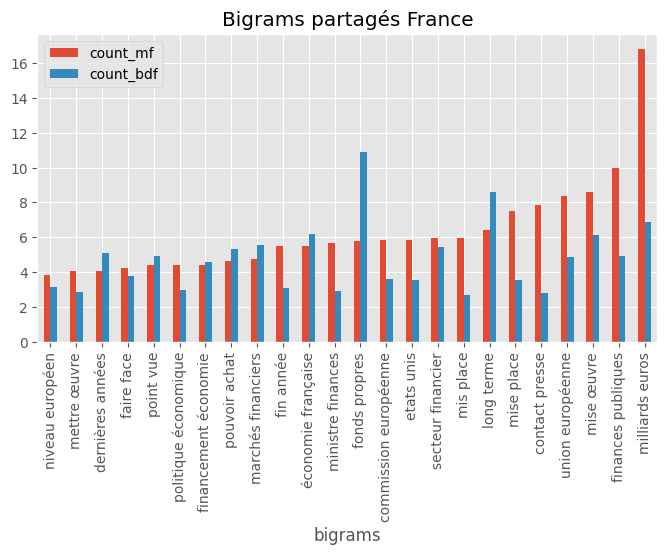

In [ ]:
cents_mots_mf_bigrams = tf_idf_score_MF_bigrams[-100:-1:1].reset_index()
cents_mots_mf_bigrams.columns =['bigrams', 'count_mf']
cents_mots_bdf_bigrams = tf_idf_score_BdF_bigrams[-100:-1:1].reset_index()
cents_mots_bdf_bigrams.columns =['bigrams', 'count_bdf']

mots_partage = pd.merge(cents_mots_mf_bigrams , cents_mots_bdf_bigrams, on=["bigrams"], how='inner')
mots_partage
mots_partage.plot(kind='bar', x='bigrams', figsize = (8, 4), title='Bigrams partagés France');

### Allemagne

In [ ]:
vectorizer_BB_bigrams,dtm_BB_bigrams=TF_IDF_Bigrams(jsons_data_BB,stopwords_de)
vectorizer_BMF_bigrams,dtm_BMF_bigrams=TF_IDF_Bigrams(jsons_data_BMF,stopwords_de)

In [ ]:
tf_idf_score_BB_bigrams = pd.DataFrame(dtm_BB_bigrams.toarray().sum(axis=0),index= vectorizer_BB_bigrams.get_feature_names_out()).sort_values(by=0)

In [ ]:
tf_idf_score_BMF_bigrams = pd.DataFrame(dtm_BMF_bigrams.toarray().sum(axis=0),index= vectorizer_BMF_bigrams.get_feature_names_out()).sort_values(by=0)

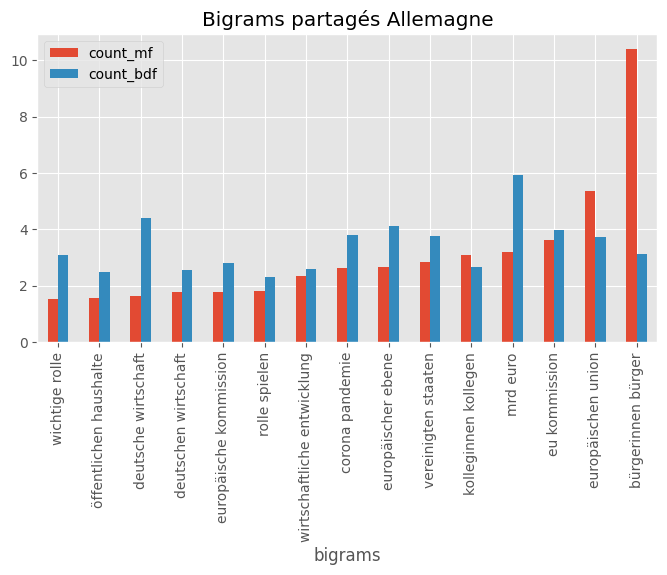

In [ ]:
cents_mots_bmf_bigrams = tf_idf_score_BMF_bigrams[-100:-1:1].reset_index()
cents_mots_bmf_bigrams.columns =['bigrams', 'count_mf']
cents_mots_bb_bigrams = tf_idf_score_BB_bigrams[-100:-1:1].reset_index()
cents_mots_bb_bigrams.columns =['bigrams', 'count_bdf']

mots_partage = pd.merge(cents_mots_bmf_bigrams , cents_mots_bb_bigrams, on=["bigrams"], how='inner')
mots_partage
mots_partage.plot(kind='bar', x='bigrams', figsize = (8, 4), title='Bigrams partagés Allemagne');

La vectorisation TF-IDF a montré que 45% de unigrams et 35% de bigrams les plus populaires utilisés dans les discours sont partagés entre la Banque de France et le Ministère des Finances. Pour l'Allemage, le taux s'élève à 32% et 14% respectivement. Le résultat est plutôt satisfaisant car il n'y a pas de mots non pertinents parmi les unigrams. Ce n'est pas le cas pour les bigrams, où nous trouvons des mots comme "contact presse", "mise [en] oeuvre", etc. qui semblent hors sujet. Cela nous montre que la vectorisation a des difficultés à trouver des bigrams pertinents. Bien que cette approche vectorielle très simple du traitement du langage naturel soit très limitée, elle peut néanmoins nous fournir une première confirmation que notre hypothèse mérite d'être étudiée plus en détail.


# NMF Topic Model

## Non negatif matrix factorization

La factorisation de matrices non négatives (NMF) est un algorithme dans lesquels une matrice $\mathbf{V}$ est factorisée en (généralement) deux matrices  $\mathbf{W}$  et  $\mathbf{H}$  avec la propriété que les trois matrices n'ont pas d'éléments négatifs. </b>

La NMF permet de réduire la dimension de notre corpus pour accorder une pondération comparativement plus faible aux mots moins cohérents. Dans notre situation, $\mathbf{V}$ représente la matrice des documents de termes, chaque ligne de la matrice $\mathbf{H}$ est un enchâssement de mots et chaque colonne de la matrice $\mathbf{W}$ représente le poids de chaque mot obtenu dans chaque phrase (relation sémantique des mots avec chaque phrase).  </b>

![](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)

On suppose ici que toutes les entrées de $\mathbf{W}$ et $\mathbf{H}$ sont positives étant donné que toutes les entrées de $\mathbf{V}$ sont positives. Dans la matrice des termes du document (matrice d'entrée), nous avons des documents individuels sur les lignes de la matrice et chaque terme unique sur les colonnes. Chaque mot de la matrice des termes du document est pris en compte. Lors de la factorisation, chacun des mots se voit attribuer un poids basé sur la relation sémantique entre les mots. Le mot qui a le poids le plus élevé est considéré comme le sujet d'un ensemble de mots. De cette manière, nous pouvons extraire des sujets de notre corpus.





In [ ]:
from sklearn.decomposition import NMF

In [ ]:
# Définition d'une fonction pour trouver les topics et les mots par topic
def get_topics(dtm,vectorizer,ntopics=7,nwords=15):
    nmf_model= NMF(n_components=ntopics)
    nmf_model.fit(dtm)
    topics=[]
    for index,topic in enumerate(nmf_model.components_):
        print(f'Les {nwords} mots les plus importants pour topic #{index}')
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
        topics.append([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
        print('\n')
    return topics,nmf_model

### France

In [ ]:
# Application de la fonction à la Banque de France
topics_BdF, nmf_model_BdF = get_topics(dtm_BdF,vectorizer_BdF,ntopics=5,nwords=10)

Les 10 mots les plus importants pour topic #0
['année', 'grèce', 'réformes', 'crois', 'pays', 'veut', 'taux', 'français', 'économie', 'banques', 'faire', 'entreprises', 'oui', 'croissance', 'faut']


Les 10 mots les plus importants pour topic #1
['acpr', 'financement', 'marchés', 'marché', 'bâle', 'financier', 'système', 'liquidité', 'fonds', 'risque', 'crise', 'bancaire', 'financière', 'risques', 'banques']


Les 10 mots les plus importants pour topic #2
['hausse', 'terme', 'bce', 'achats', 'centrales', 'stabilité', 'zone', 'intérêt', 'euro', 'anticipations', 'prix', 'politique', 'monétaire', 'taux', 'inflation']


Les 10 mots les plus importants pour topic #3
['risques', 'sécurité', 'fintech', 'stablecoins', 'services', 'actifs', 'règlement', 'numérique', 'innovation', 'acteurs', 'monnaie', 'crypto', 'mnbc', 'paiement', 'paiements']


Les 10 mots les plus importants pour topic #4
['états', 'européenne', 'investissement', 'européen', 'budgétaire', 'politique', 'réformes', 'économique'

On pourra définir les topics de la Banque de Frace de manière suivante:

*   Topic 0 = Crise de la dette dans la zone euro
*   Topic 1 = Stabilité financière
*   Topic 2 = Politique monétaire 
*   Topic 3 = Système de paiements 
*   Topic 4 = Politique budgétaire 

In [ ]:
# Application de la fonction au Ministère
topics_MF,nmf_model_MF=get_topics(dtm_MF,vectorizer_MF,ntopics=5,nwords=10)

Les 10 mots les plus importants pour topic #0
['salariés', 'devons', 'européenne', 'français', 'politique', 'pays', 'crise', 'prononcé', 'foi', 'europe', 'économique', 'faire', 'faut', 'entreprises', 'france']


Les 10 mots les plus importants pour topic #1
['france', 'services', 'presse', 'appel', 'ministère', 'chargé', 'ministre', 'entreprises', 'économie', 'développement', 'emploi', 'commerce', 'projets', 'numérique', 'industrie']


Les 10 mots les plus importants pour topic #2
['économies', 'loi', 'mesures', 'milliards', 'dépense', 'comptes', 'publiques', 'finances', 'budget', 'baisse', 'année', 'euros', 'impôt', 'dépenses', 'déficit']


Les 10 mots les plus importants pour topic #3
['disponibilités', 'position', 'cours', 'dts', 'diminué', 'mois', 'or', 'créances', 'fin', 'augmenté', 'change', 'avoirs', 'fmi', 'devises', 'réserves']


Les 10 mots les plus importants pour topic #4
['transparence', 'bancaire', 'place', 'projet', 'financement', 'comité', 'financier', 'corruption', 'ba

On pourra définir les topics du Ministère des Finances de manière suivante:
*   Topic 0 = Crise de la dette dans la zone euro
*   Topic 1 = Politique conjoncturelle 
*   Topic 2 = Politique budgétaire 
*   Topic 3 = Système de paiements 
*   Topic 4 = Politique monétaire 


In [ ]:
def gen_wordcloud(topics, institution):
    for i,elem in enumerate(topics):
            print(f"{lang} TOPIC {i}")
            wordcloud = WordCloud(max_words=60).generate(" ".join(elem))
            # Display the generated image:
            plt.figure(figsize=(8,10))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()

<function lang at 0x7f0e0a594a60> TOPIC 0


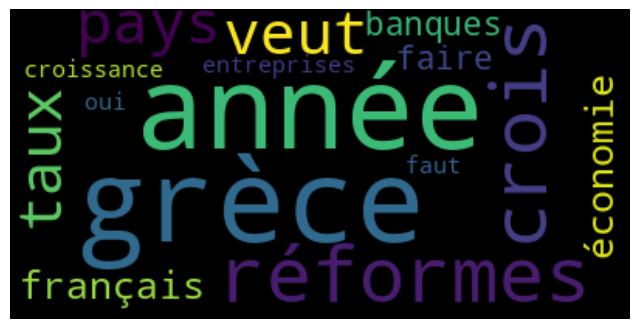

<function lang at 0x7f0e0a594a60> TOPIC 1


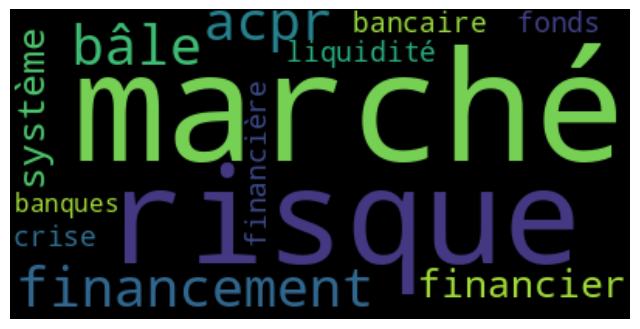

<function lang at 0x7f0e0a594a60> TOPIC 2


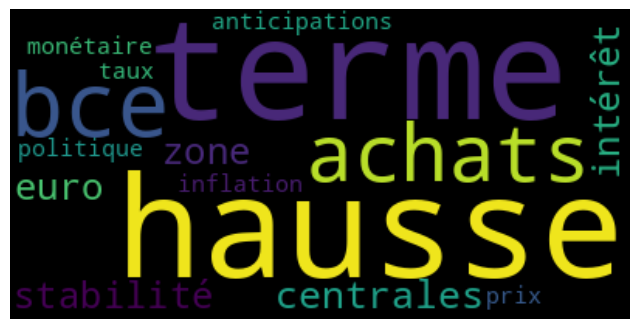

<function lang at 0x7f0e0a594a60> TOPIC 3


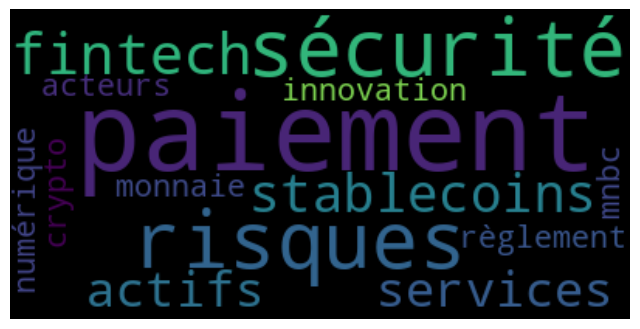

<function lang at 0x7f0e0a594a60> TOPIC 4


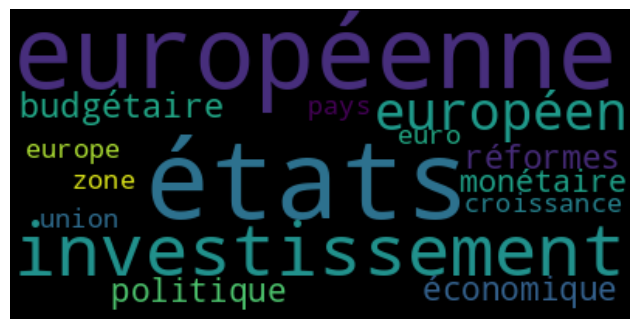

In [ ]:
gen_wordcloud(topics_BdF,"Banque de France")

<function lang at 0x7f8261907160> TOPIC 0


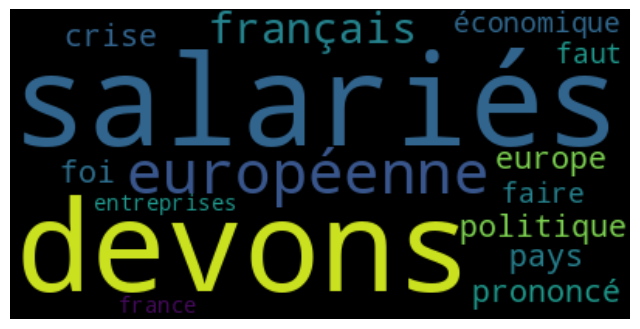

<function lang at 0x7f8261907160> TOPIC 1


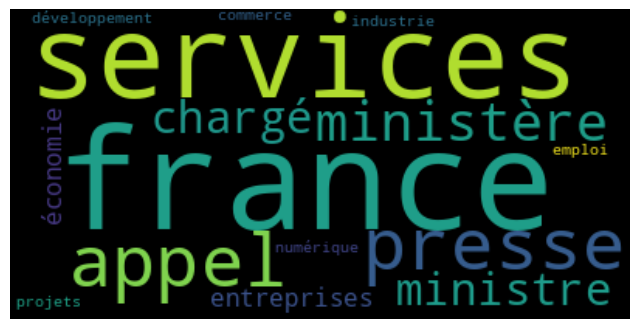

<function lang at 0x7f8261907160> TOPIC 2


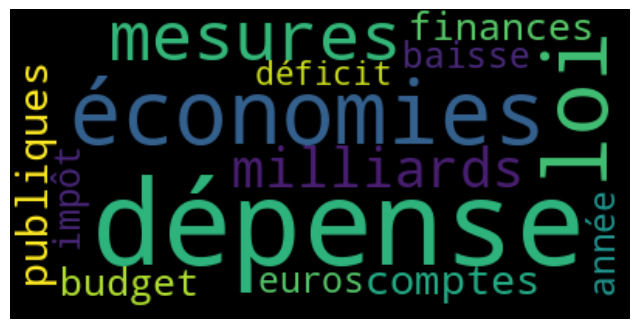

<function lang at 0x7f8261907160> TOPIC 3


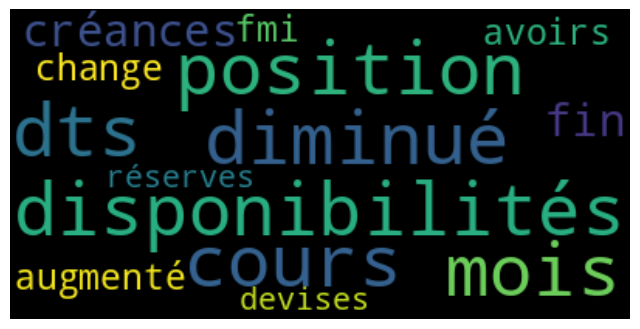

<function lang at 0x7f8261907160> TOPIC 4


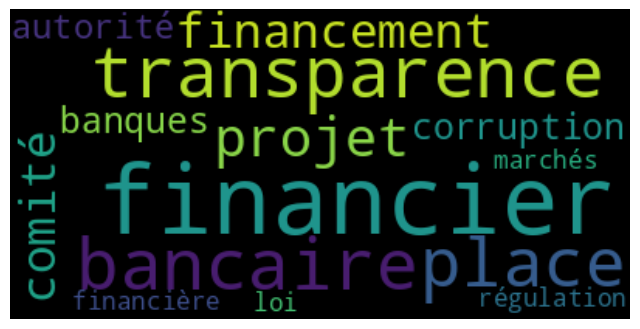

In [ ]:
gen_wordcloud(topics_MF,"Ministère des Finances")

### Allemagne

In [ ]:
# Application de la fonction à la Bundesbank 
topics_BB, nmf_model_BB = get_topics(dtm_BB,vectorizer_BB,ntopics=5,nwords=10)

Les 10 mots les plus importants pour topic #0
['europa', 'banken', 'europäische', 'haftung', 'bankenunion', 'staatsanleihen', 'europäischen', 'länder', 'staaten', 'geldpolitik', 'mitgliedstaaten', 'raum', 'krise', 'euro', 'währungsunion']


Les 10 mots les plus importants pour topic #1
['sepa', 'jahres', 'finanzmärkten', 'finanzkrise', 'euro', 'letzten', 'deutschen', 'deutschland', 'krise', 'deutsche', 'zentrale', 'kommunikation', 'gebeten', 'verwertung', 'bundesbank']


Les 10 mots les plus importants pour topic #2
['smartphone', 'geld', 'digitalisierung', 'blockchain', 'instant', 'payments', 'digitale', 'zentralbankgeld', 'bezahlen', 'zahlungen', 'sepa', 'euro', 'digitalen', 'zahlungsverkehr', 'bargeld']


Les 10 mots les plus importants pour topic #3
['aufseher', 'baseler', 'finanzsystem', 'bankenaufsicht', 'digitalisierung', 'deutschen', 'regeln', 'iii', 'sparkassen', 'basel', 'risiken', 'aufsicht', 'regulierung', 'institute', 'banken']


Les 10 mots les plus importants pour topic 

On pourra définir les topics de manière suivante: 

*   Topic 0 = Crise de la dette dans la zone euro
*   Topic 1 = sans intérêt 
*   Topic 2 = Système de paiements
*   Topic 3 = Stabilité financière 
*   Topic 4 = Politique monétaire 

In [ ]:
# Application de la fonction au Bundesfinanzministerium
topics_BMF,nmf_model_BMF=get_topics(dtm_BMF,vectorizer_BMF,ntopics=5,nwords=10) 

Les 10 mots les plus importants pour topic #0
['gemeinsamen', 'gemeinsame', 'währungsunion', 'krise', 'europäischer', 'staaten', 'mitgliedstaaten', 'europas', 'banken', 'deutschland', 'union', 'europäische', 'eu', 'europäischen', 'europa']


Les 10 mots les plus importants pour topic #1
['deutschland', 'geld', 'staat', 'bundeswehr', 'krise', 'milliarden', 'funke', 'ukraine', 'pandemie', 'corona', 'euro', 'online', 'post', 'schuldenbremse', 'inflation']


Les 10 mots les plus importants pour topic #2
['hilfe', 'zone', 'griechenlands', 'iwf', 'athen', 'erfüllen', 'troika', 'regierung', 'griechische', 'griechen', 'griechischen', 'euro', 'programm', 'zypern', 'griechenland']


Les 10 mots les plus importants pour topic #3
['lassen', 'mittelschicht', 'deutschland', 'leute', 'geld', 'kirche', 'finanzminister', 'steuern', 'sozialstaat', 'selbstanzeige', 'kanzlerin', 'bafin', 'flut', 'wirecard', 'fas']


Les 10 mots les plus importants pour topic #4
['sagen', 'prozent', 'bürgerinnen', 'abgeord

On pourra définir les topics de manière suivante:

*   Topic 0 = Politique monétaire
*   Topic 1 = Pandemie de Corona 
*   Topic 2 = Crise de la dette dans la zone euro
*   Topic 3 = Politique conjoncturelle
*   Topic 4 = Politique Budgétaire

## Attribution des topics à chaque document

In [ ]:
# Définition d'une fonction pour attribuer les topics
def append_topic(nmf_model,dtm,data,col_name='Topic'):
    topic_results = nmf_model.transform(dtm)
    data[col_name]=topic_results.argmax(axis=1)

### France

In [ ]:
append_topic(nmf_model_BdF,dtm_BdF,jsons_data_BdF)
append_topic(nmf_model_MF,dtm_MF,jsons_data_MF)

In [ ]:
# Création d'une dictionnaire avec les topics de la Banque de France
topics_BdF = {0: 'Crise de la dette dans la zone euro', 
              1: 'Stabilité financière', 
              2: 'Politique monétaire', 
              3: 'Système de paiements', 
              4: 'Politique budgétaire'}
# Création d'une dictionnaire avec les topics du Ministère 
topics_MF =  {0: 'Crise de la dette dans la zone euro', 
              1: 'Politique conjoncturelle', 
              2: 'Politique budgétaire', 
              3: 'Système de paiements', 
              4: 'Politique monétaire'}

In [ ]:
jsons_data_BdF = jsons_data_BdF.replace({"Topic":topics_BdF})
jsons_data_MF = jsons_data_MF.replace({"Topic":topics_MF})

In [ ]:
topics_BdF_count = pd.DataFrame(jsons_data_BdF.Topic.value_counts().reset_index())
topics_BdF_count.columns = ['Topic', 'Banque de France']
topics_MF_count = pd.DataFrame(jsons_data_MF.Topic.value_counts().reset_index())
topics_MF_count.columns = ['Topic', 'Ministère des Finances']

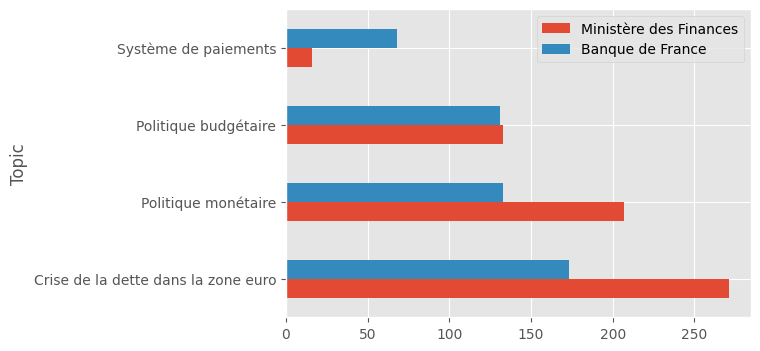

In [ ]:
combined = topics_MF_count.merge(topics_BdF_count, on="Topic").set_index("Topic")
combined.plot(kind='barh', figsize=(6,4));

### Allemagne

In [ ]:
append_topic(nmf_model_BB,dtm_BB,jsons_data_BB)
append_topic(nmf_model_BMF,dtm_BMF,jsons_data_BMF)

In [ ]:
# Création d'une dictionnaire avec les topics de la Bundesbank
topics_BdF = {0: 'Crise de la dette dans la zone euro', 
              1: 'sans intérêt', 
              2: 'Système de paiements', 
              3: 'Stabilité financière', 
              4: 'Politique monétaire'}
# Création d'une dictionnaire avec les topics du Bundesfinanzministerium 
topics_MF =  {0: 'Politique monétaire', 
              1: 'Pandemie de Corona', 
              2: 'Crise de la dette dans la zone euro', 
              3: 'Politique conjoncturelle', 
              4: 'Politique budgétaire'}

In [ ]:
jsons_data_BB = jsons_data_BB.replace({"Topic":topics_BdF})
jsons_data_BMF = jsons_data_BMF.replace({"Topic":topics_MF})

In [ ]:
topics_BB_count = pd.DataFrame(jsons_data_BB.Topic.value_counts().reset_index())
topics_BB_count.columns = ['Topic', 'Bundesbank']
topics_BMF_count = pd.DataFrame(jsons_data_BMF.Topic.value_counts().reset_index())
topics_BMF_count.columns = ['Topic', 'Bundesfinanzministerium']

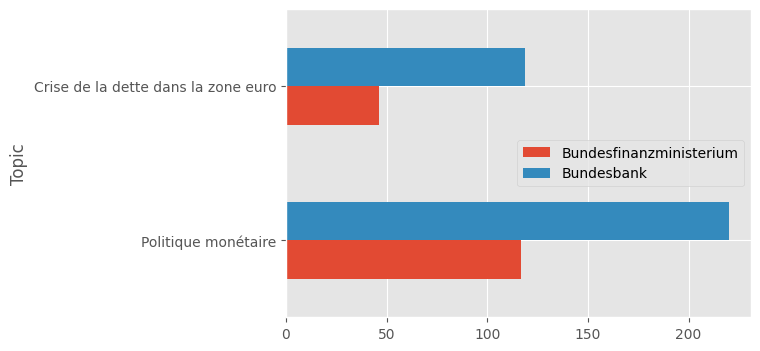

In [ ]:
combined = topics_BMF_count.merge(topics_BB_count, on="Topic").set_index("Topic")
combined.plot(kind='barh', figsize=(6,4));

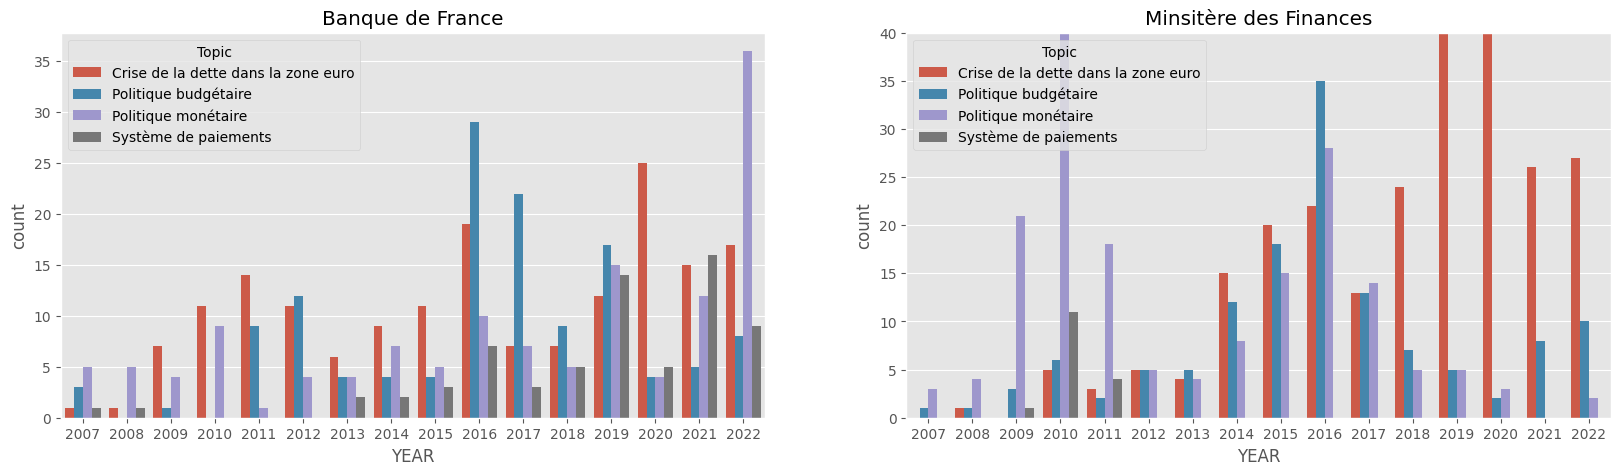

In [ ]:
# Création d'une colonne avec les dates en trimestre 
jsons_data_MF['YEAR'] = jsons_data_MF['DATE'].dt.to_period('Y')
jsons_data_BdF['YEAR'] = jsons_data_BdF['DATE'].dt.to_period('Y')

data1 = jsons_data_BdF.drop(jsons_data_BdF[jsons_data_BdF.Topic == 'Stabilité financière'].index)
data2 = jsons_data_MF.drop(jsons_data_MF[jsons_data_MF.Topic == 'Politique conjoncturelle'].index)

plt.figure(figsize=(20,5))
plt.subplot(121)
ax = sns.countplot(x=data1['YEAR'].sort_values(), hue=data1['Topic'].sort_values(), data=data1).set(title="Banque de France")
plt.subplot(122)
ax1 = sns.countplot(x=data2['YEAR'].sort_values(),hue=data2['Topic'].sort_values(), data=data2).set(title="Minsitère des Finances")
plt.ylim(0, 40);

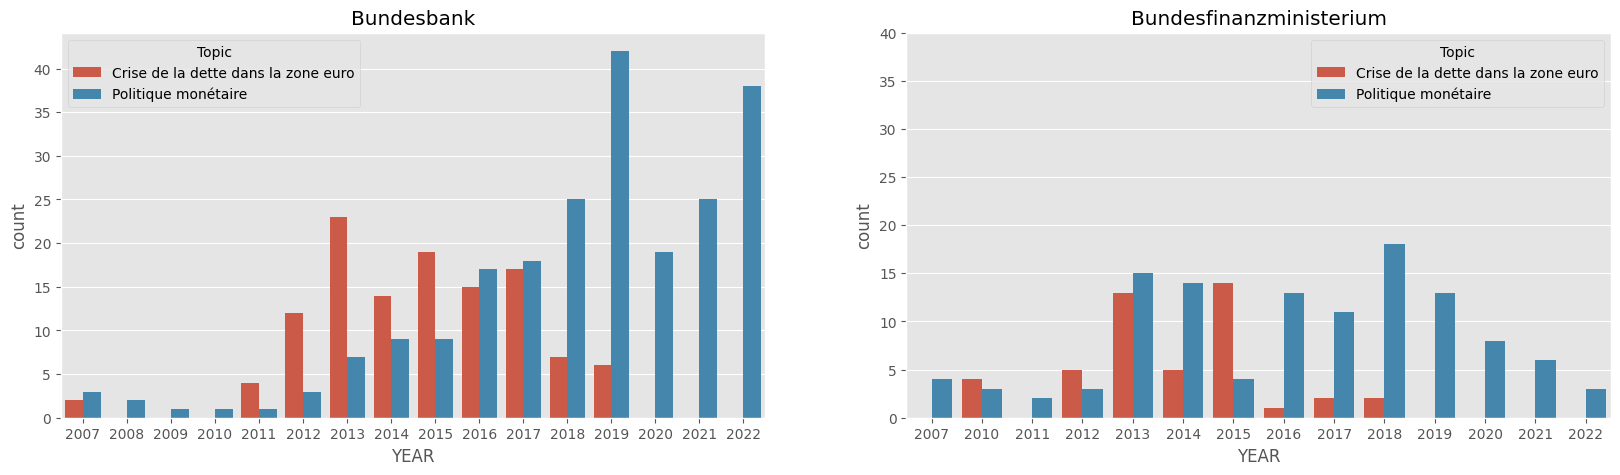

In [ ]:
# Création d'une colonne avec les dates en trimestre 
jsons_data_BMF['YEAR'] = jsons_data_BMF['DATE'].dt.to_period('Y')
jsons_data_BB['YEAR'] = jsons_data_BB['DATE'].dt.to_period('Y')

data1 = jsons_data_BB[(jsons_data_BB.Topic == 'Crise de la dette dans la zone euro') | (jsons_data_BB.Topic == 'Politique monétaire')]
data2 = jsons_data_BMF[(jsons_data_BMF.Topic == 'Crise de la dette dans la zone euro') | (jsons_data_BMF.Topic == 'Politique monétaire')]

plt.figure(figsize=(20,5))
plt.subplot(121)
ax = sns.countplot(x=data1['YEAR'].sort_values(), hue=data1['Topic'].sort_values(), data=data1).set(title="Bundesbank")
plt.subplot(122)
ax1 = sns.countplot(x=data2['YEAR'].sort_values(),hue=data2['Topic'].sort_values(), data=data2).set(title="Bundesfinanzministerium")
plt.ylim(0, 40);

En attribuant des thèmes à chaque document, on constate que les thèmes partagés entre les autorités budgétaires et monétaires évoluent dans le temps. On peut également constater que moins de topics sont partagé entre les deux institutions en Allemagne qu'en France, ce qui pourrait être signe d'une plus grande indépendance institutionnelle en Allemagne.</br>
En ce qui concerne l'hypothèse de la dominance fiscale, on peut constater que le thème de la politique budgétaire, qui est le thème le plus pertinent pour une autorité fiscale, augmente en moyenne pour la Banque de France, avec un pic en 2016. Cela pourrait être une indication du fait que la politique monétaire est effectivement subordonnée aux politiques fiscales. Une analyse plus granulaire pourrait fournir des preuves plus solides de cette observation.</br>
C'est également intéressant d'observer que la crise de 2007/2008 ne joue plus aucun rôle dans les discours en Allemagne à partir de 2019 or qu'en France elle semble augmenter d'importance, surtout dans les discours du ministère.</br>
Pour l'Allemagne, l'hypothèse est plus difficile à tester comme le topic de la politique budgétaire n'a pas été trouvé avec le modèle NMF. Pourtant, on peut constater que la politique monétaire est un topic important pour le ministère des Finances en Allemagne.</br>
